# IED sequence detection

This notebook detects IEDs and groups them into sequences. This includes:
* Loading an EDF file containing the recordings and keeping a defined subset of all channels.
* Running an IED detection algorithm.
* Grouping IEDs into sequences across channels.
* Doing a basic EDA by producing some plots.

In [73]:
import scipy
import scipy.io
from scipy import signal
import scipy.stats as stats

from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.impute import SimpleImputer

from yellowbrick.cluster import KElbowVisualizer

import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
import seaborn as sns
import math
import pyedflib
from tqdm import tqdm
import pandas as pd
from matplotlib.colors import LogNorm

matplotlib.rcParams['figure.figsize'] = (20, 10)

%run DetectSpike_SEEG.py

Open the file

In [19]:
file_name = 'Data/TrialPatientBeSa/X~ X_74addeec-ea9c-4b25-8280-cab2db067651.EDF'
# file_name = 'Data/TrialPatientArRa/X~ X_2fc7b4bb-d0f1-45b1-b60d-0ec24a942259.EDF'

f = pyedflib.EdfReader(file_name)

Define file specific parameters

In [20]:
freq = f.getSampleFrequencies()[0]

Get channels and number of channels

In [21]:
signal_labels = f.getSignalLabels()

Get list of channels to use from channels.mat

In [22]:
# mat = scipy.io.loadmat('Data/TrialPatientArRa/channels.mat')
# valid_channels = [channel[0] for channel in mat['channels'][:, 0]]

# Load file containing suitable channels and convert to list
df = pd.read_excel('Data/TrialPatientBeSa/BeSA/sub-01/Electrodes.xlsx', header=None)
valid_channels = ['EEG ' + name for name in df[0].tolist()]

Segment the data into blocks of length mins_to_process and detect IEDs in each.

In [296]:
# In minutes
mins_to_process=20

# Time points
M = f.getNSamples()[0]

SpikeIds = []
ChanIds = []

# Duration of recording in seconds
NumSecs = M / freq
Blocks = math.floor(NumSecs / (mins_to_process * 60))

# TODO do we loop through final iteration correctly? Depends on Blocks calculation 
# Iterate through each block of mins_to_process minutes
# TODO use full dataset eventually (currently using subset)
for current_block in tqdm(range(4, 30)):

    data_block = np.zeros((len(valid_channels), freq * 60 * mins_to_process))

    # Populate area of data for the current block across all channels
    for i, chan in enumerate(valid_channels):

        data_block[i, :] = f.readSignal(signal_labels.index(chan), \
                                        start = current_block * freq * 60 * mins_to_process, \
                                        n = freq * 60 * mins_to_process)

    # Detect IEDs in current block across all chanels
    SpikeIndex, ChanId, _ = DetectSpikes(data_block, freq, STDCoeff=2)
    
    # Add to list across all blocks, corrected for index of block start
    SpikeIds.append(SpikeIndex + current_block * freq * 60 * mins_to_process)
    ChanIds.append(ChanId)

# Convert to numpy arrays
SpikeIds = np.concatenate(SpikeIds, axis=0)
ChanIds = np.concatenate(ChanIds, axis=0)

100%|██████████| 26/26 [37:49<00:00, 87.27s/it]


Plot histogram of inter-IED intervals.

Text(0.5, 6.79999999999999, 'Time (s)')

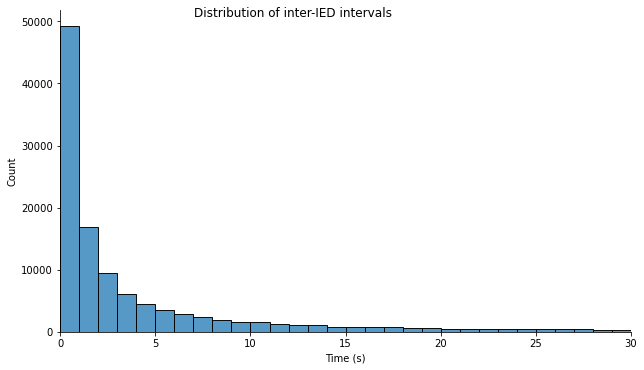

In [163]:
# Difference in time between IEDs
diffs = np.zeros((1))
for channel in np.unique(ChanIds):
    diffs = np.append(diffs, np.diff(SpikeIds[ChanIds == channel]))
    
diffs = diffs[1:]

# Only keep intervals < 30s
filtered_diffs = diffs[diffs / freq < 30]

# Plot using histogram
g = sns.displot(filtered_diffs / freq, bins=30)

g.fig.set_size_inches(10, 5)
g.set(xlim=(0, 30))
# g.ax.set_yscale('log')
g.fig.suptitle('Distribution of inter-IED intervals')
plt.xlabel('Time (s)')

Detect IED sequences from individual IED spikes. If an IED is within 50ms of the start of the current sequence, or 15ms from the last added spike in the sequence, it's added to the sequence.

In [69]:
SpikeIds = np.load('SpikeIds.npy')
ChanIds = np.load('ChanIds.npy')
Features = np.load('Features.npy')

freq = 2048

In [103]:
def spikes_to_sequences(SpikeIds, ChanIds):
    spikes, chans = SpikeIds.copy(), ChanIds.copy()

    spikes_argsort = np.argsort(spikes)
    spikes = list(spikes[spikes_argsort])
    chans = list(chans[spikes_argsort])

    # 50ms and 15ms in indices (using known frequency)
    fifty_ms = int(round(freq * 0.05))
    fifteen_ms = int(round(freq * 0.015))

    # Lists for all sequences, one for spike indices and one for channels
    all_seq_spikes = []
    all_seq_chans = []

    # While there are unprocessed spikes 
    while len(spikes) > 0:

        # Start a list with the leading spike
        seq_spikes = [spikes.pop(0)]
        seq_chans = [chans.pop(0)]

        curr_spike = seq_spikes[0]

        # For remaining spikes
        for spike in spikes:
            # If spike is within 15ms of last spike in sequence or 50ms of first
            if spike - seq_spikes[0] <= fifty_ms or spike - curr_spike <= fifteen_ms:
                # Then add to sequence
                curr_spike = spike

                seq_spikes.append(spikes.pop(0))
                seq_chans.append(chans.pop(0))

            # When no more eligible spikes, move to next sequence
            else:
                break

        # Add processed sequence to list of sequences
        all_seq_spikes.append(seq_spikes)
        all_seq_chans.append(seq_chans)
        
    return all_seq_spikes, all_seq_chans

In [104]:
all_seq_spikes, all_seq_chans = spikes_to_sequences(SpikeIds, ChanIds)

In [71]:
all_seq_spikes_sparse = np.zeros((len(all_seq_spikes), len(valid_channels)))

for i, chans in enumerate(all_seq_chans):
    for chan in chans:
        all_seq_spikes_sparse[i, chan] = 1

In [74]:
svd = TruncatedSVD(n_components=len(valid_channels) // 2)
svd.fit(all_seq_spikes_sparse)

n_components = np.argmax(svd.explained_variance_ratio_.cumsum() > 0.8) + 1

all_seq_spikes_svd = TruncatedSVD(n_components=n_components).fit_transform(all_seq_spikes_sparse)

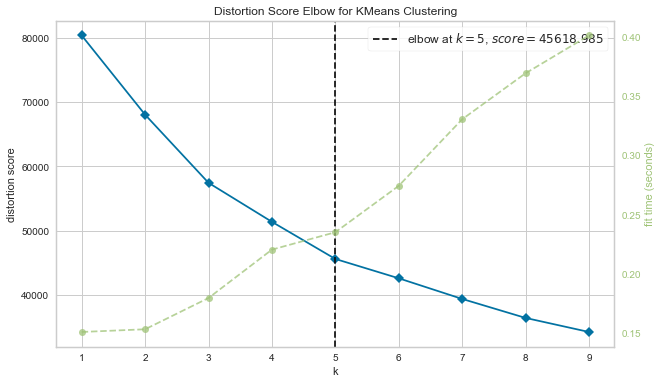

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [75]:
matplotlib.rcParams['figure.figsize'] = (10, 6)

kmeans = KMeans()
visualizer = KElbowVisualizer(kmeans, k=(1, 10))

visualizer.fit(all_seq_spikes_svd)        # Fit the data to the visualizer
visualizer.show()

In [76]:
n_clusters = visualizer.elbow_value_

kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(all_seq_spikes_svd)

assigned_clusters = kmeans.predict(all_seq_spikes_svd)

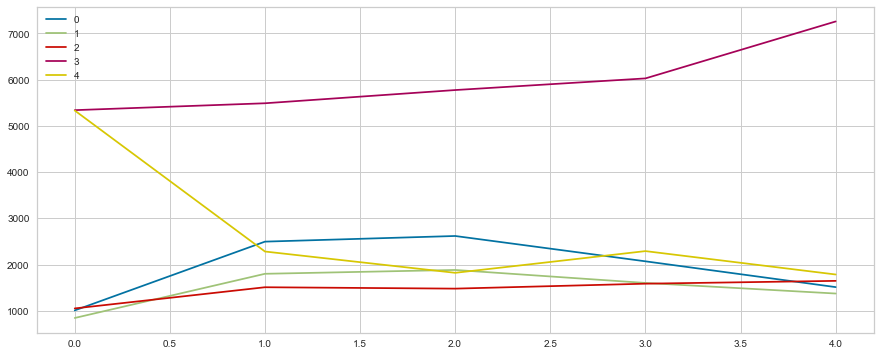

In [77]:
matplotlib.rcParams['figure.figsize'] = (15, 6)

window = len(assigned_clusters) // 5
counts = []

for i in range(len(assigned_clusters) // window):
    counts.append(np.unique(assigned_clusters[i * window : (i + 1) * window], return_counts=True)[1])
        
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(counts)
ax.legend(labels=np.unique(assigned_clusters))

In [79]:
np.unique(assigned_clusters, return_counts=True, axis=0)[1]

array([ 9704,  7502,  7272, 29895, 13513])

In [89]:
def matshow_cluster(cluster_num=None):

    if cluster_num is not None:
        # If a sequence is A -> B -> C, count A -> B as one connection and B -> C as another.
        starts_list = [chan[:-1] for cluster, chan in zip(assigned_clusters, all_seq_chans) if len(chan) >= 2 and cluster == cluster_num]
        ends_list = [chan[1:] for cluster, chan in zip(assigned_clusters, all_seq_chans) if len(chan) >= 2 and cluster == cluster_num]
    else:
        starts_list = [chan[:-1] for cluster, chan in zip(assigned_clusters, all_seq_chans) if len(chan) >= 2]
        ends_list = [chan[1:] for cluster, chan in zip(assigned_clusters, all_seq_chans) if len(chan) >= 2]

    pairs = []

    for starts, ends in zip(starts_list, ends_list):
        for start, end in zip(starts, ends):
            pairs.append([int(start), int(end)])

    unique, counts = np.unique(pairs, return_counts=True, axis=0)

    sorted_counts = np.flip(np.argsort(counts))
    counts = counts[sorted_counts]
    unique = unique[sorted_counts]

    matplotlib.rcParams['figure.figsize'] = (30, 30)

    chans = len(valid_channels)

    # Produce the matrix
    counts_mat = np.zeros((chans, chans))
    for c, u in zip(counts, unique):
        counts_mat[u[0]][u[1]] = c

    # Display as a heatmap
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(counts_mat + 1, interpolation='nearest', norm=LogNorm(), cmap='viridis')
    ax.grid(False)
    fig.colorbar(cax)

    # Set ticks as appropriate
    xaxis = np.arange(chans)
    ax.set_xticks(xaxis)
    ax.set_yticks(xaxis)
    ax.set_xticklabels(valid_channels, rotation=90)
    ax.set_yticklabels(valid_channels)

    plt.show()

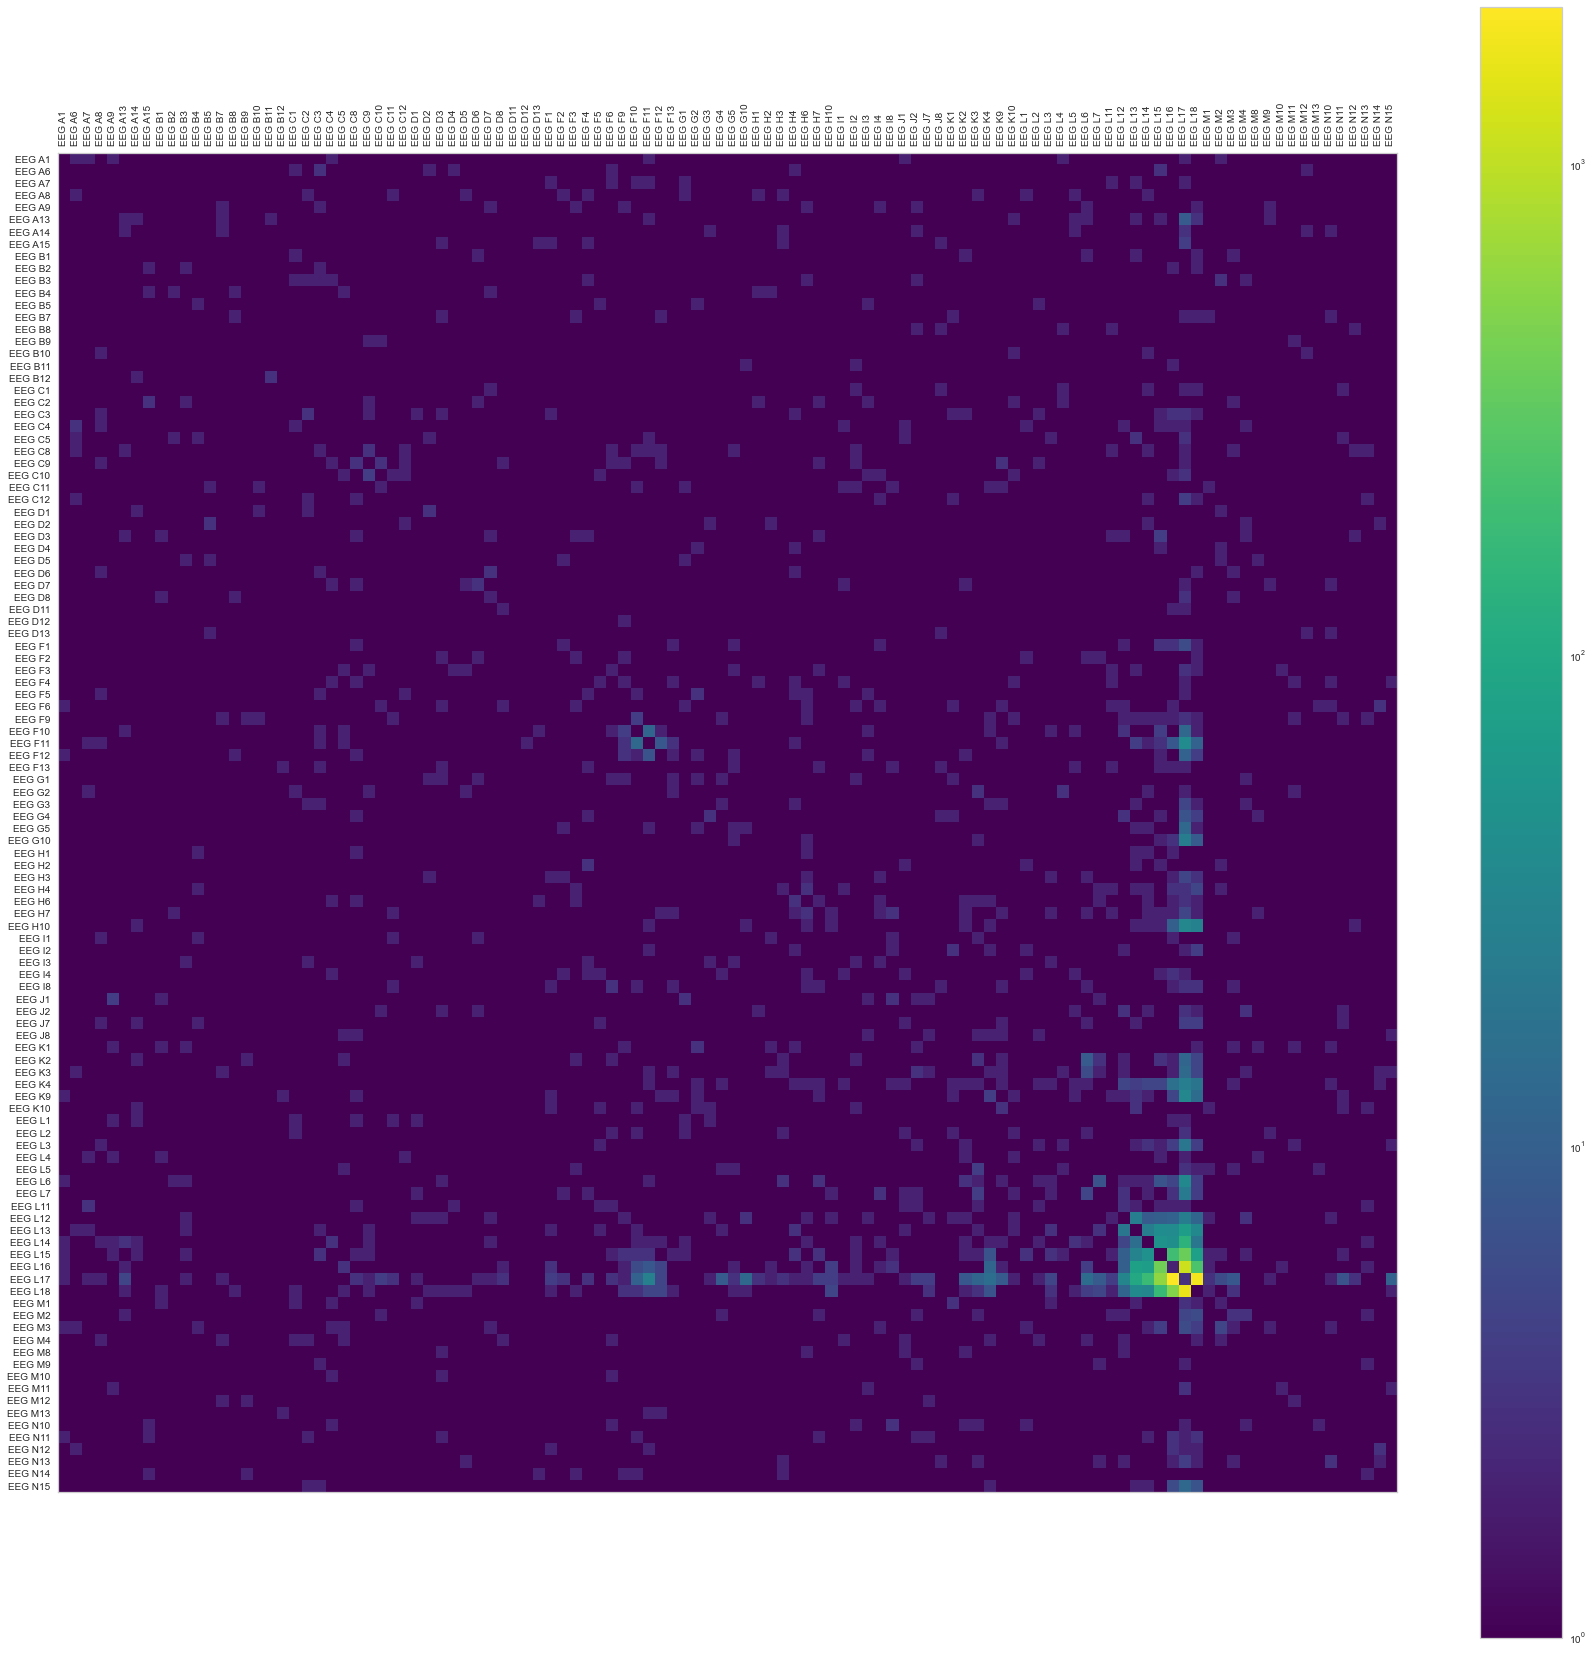

In [90]:
matshow_cluster(0)

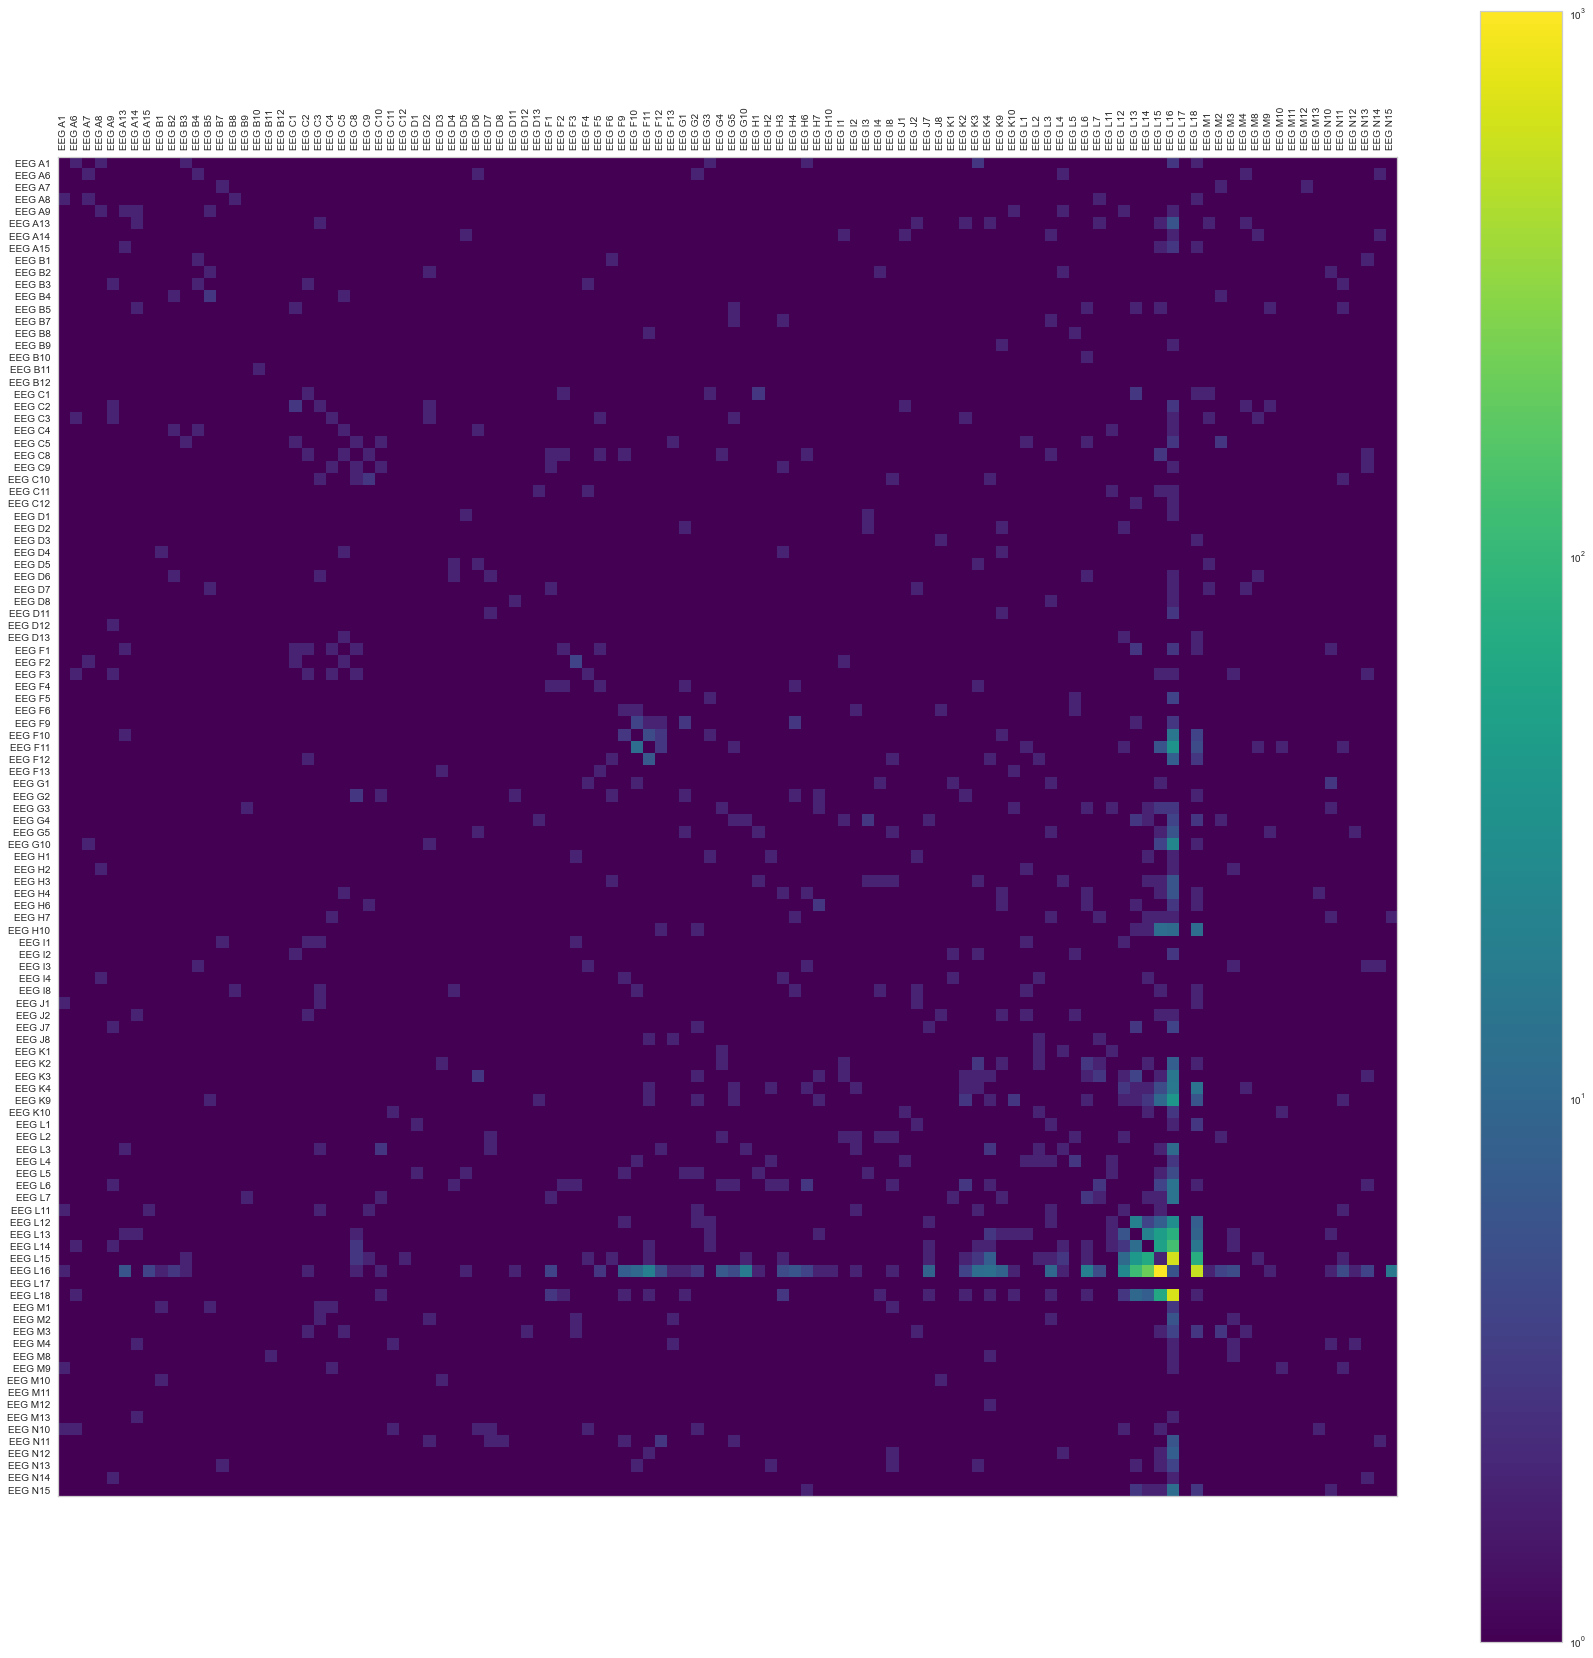

In [91]:
matshow_cluster(1)

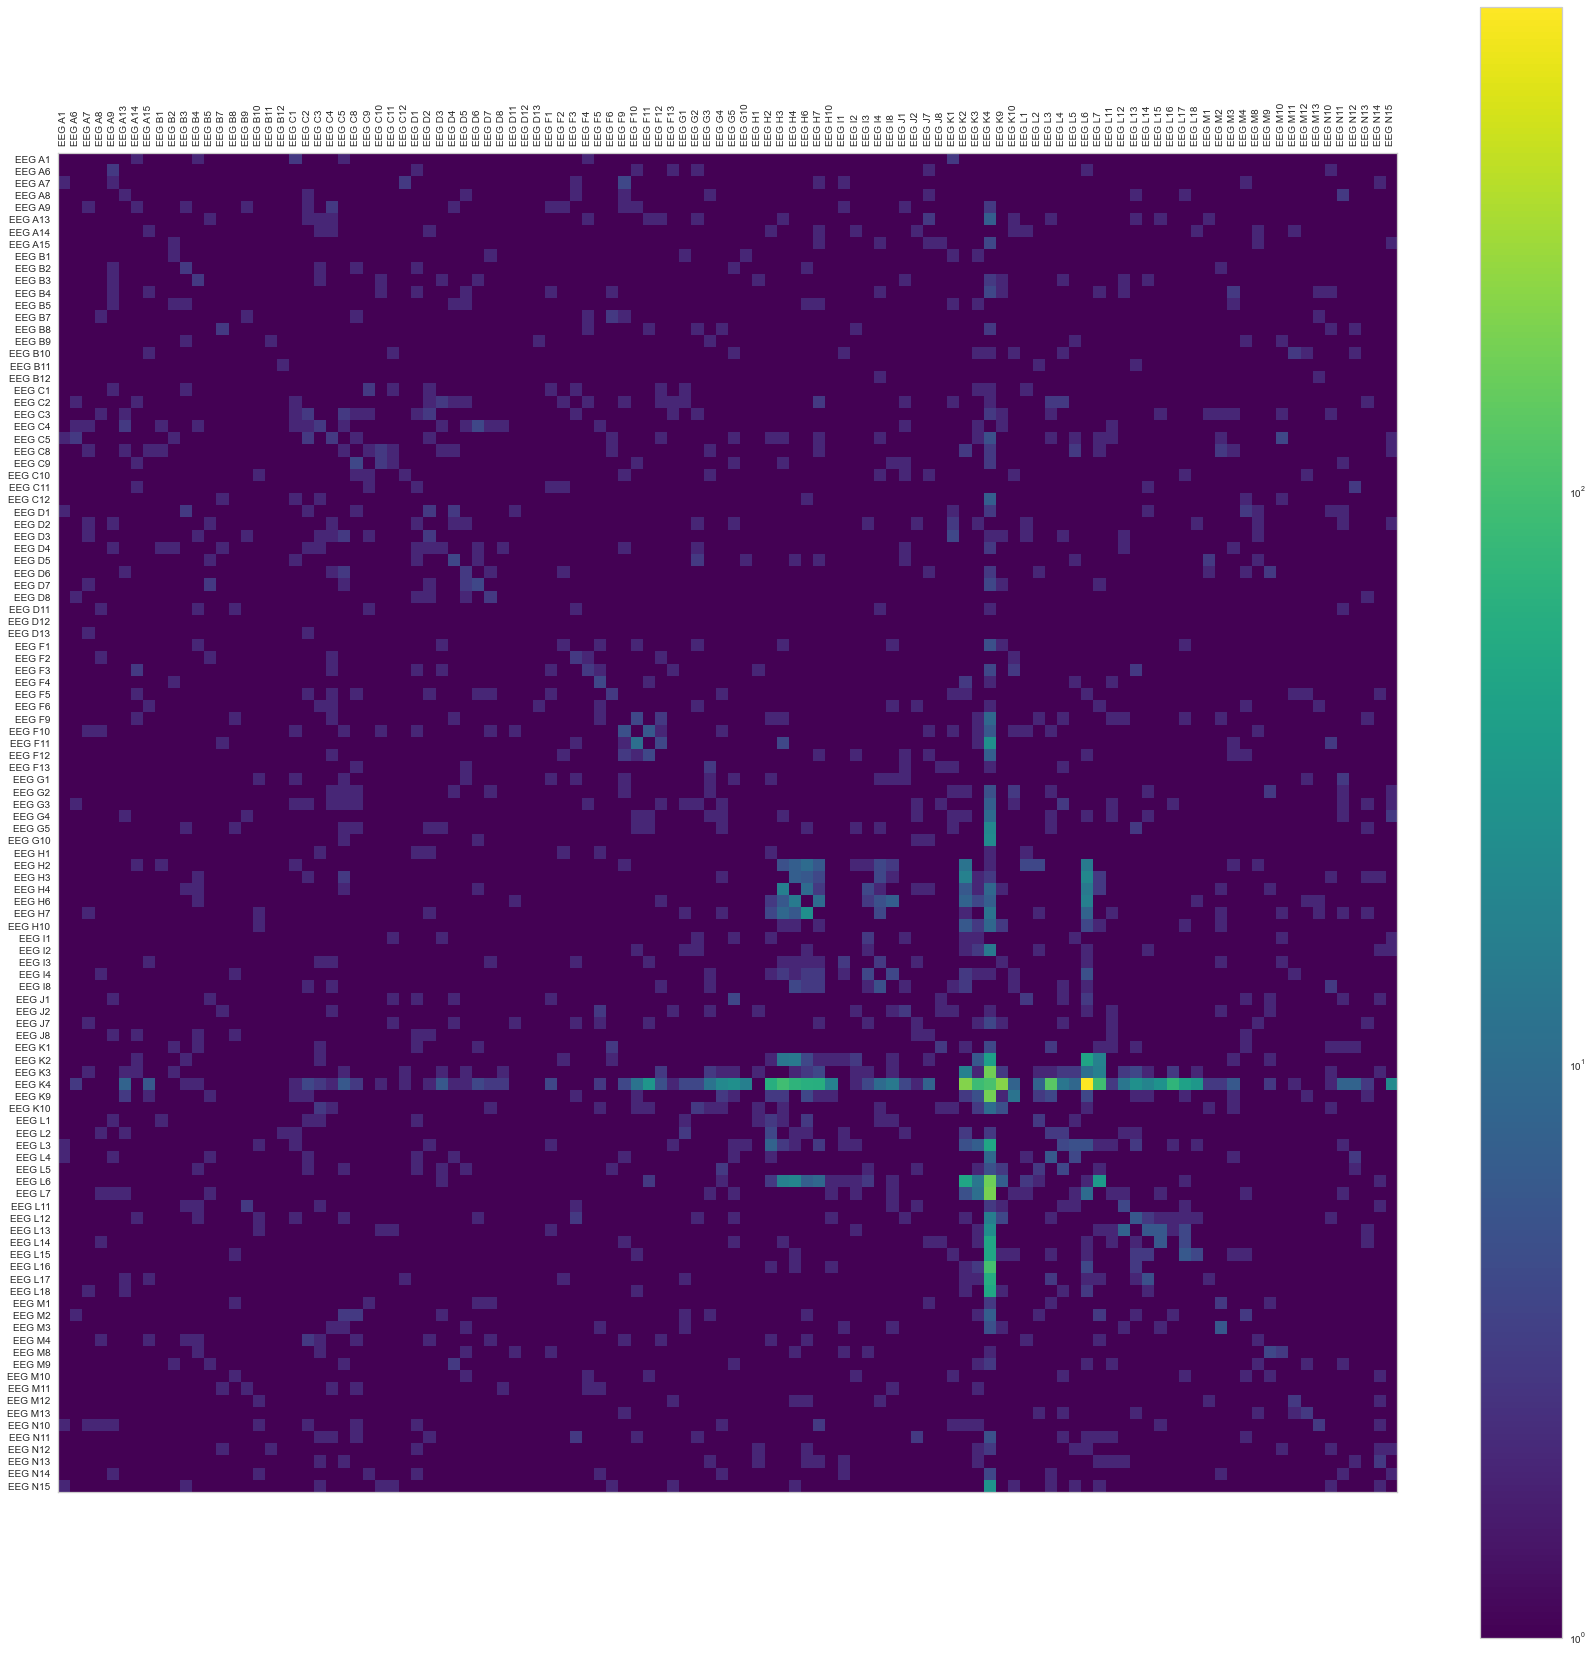

In [92]:
matshow_cluster(2)

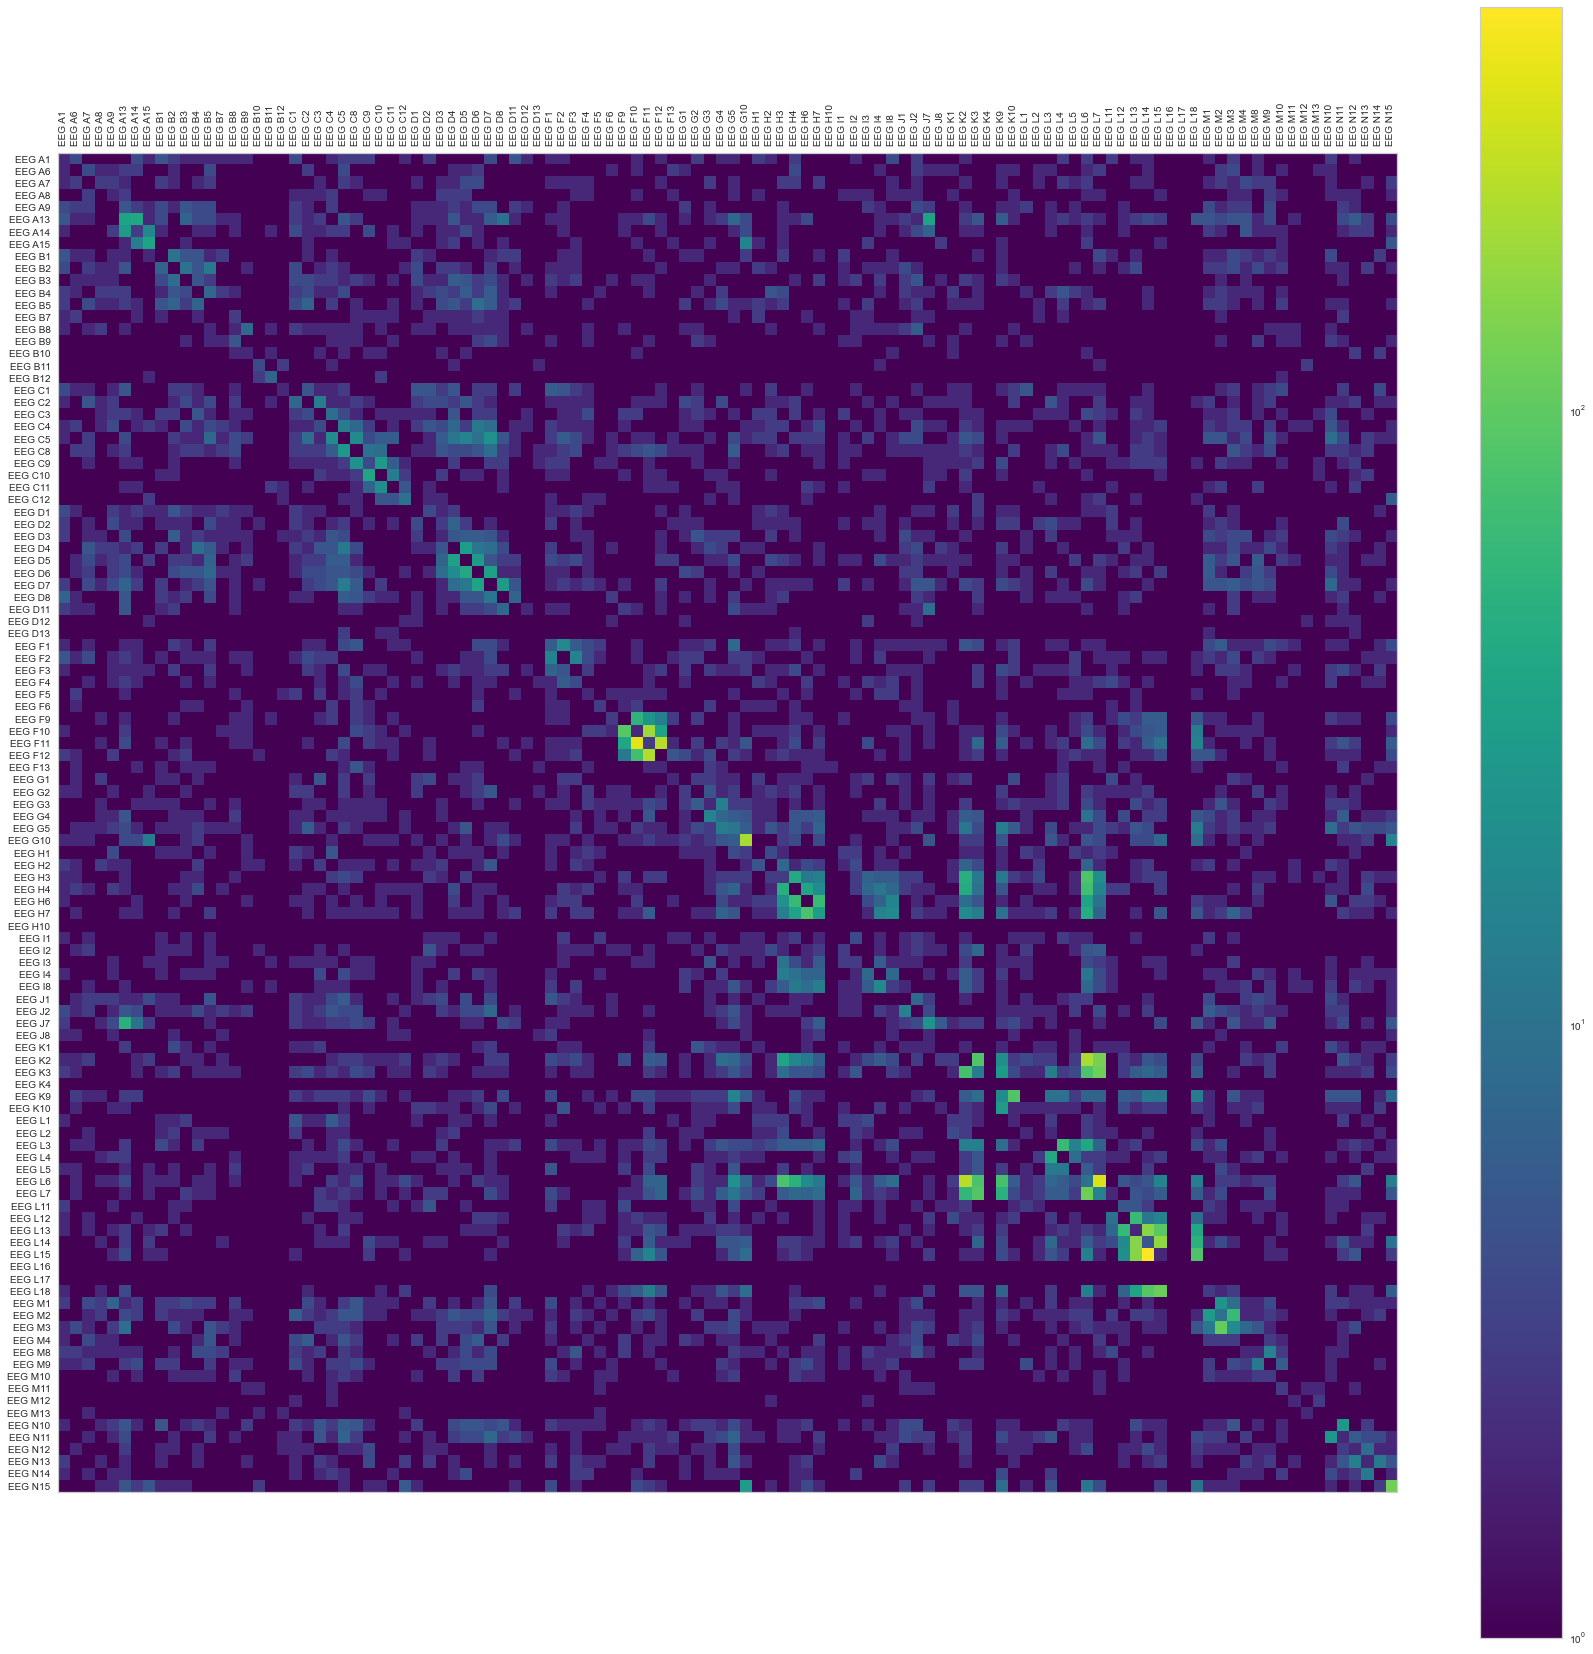

In [95]:
matshow_cluster(3)

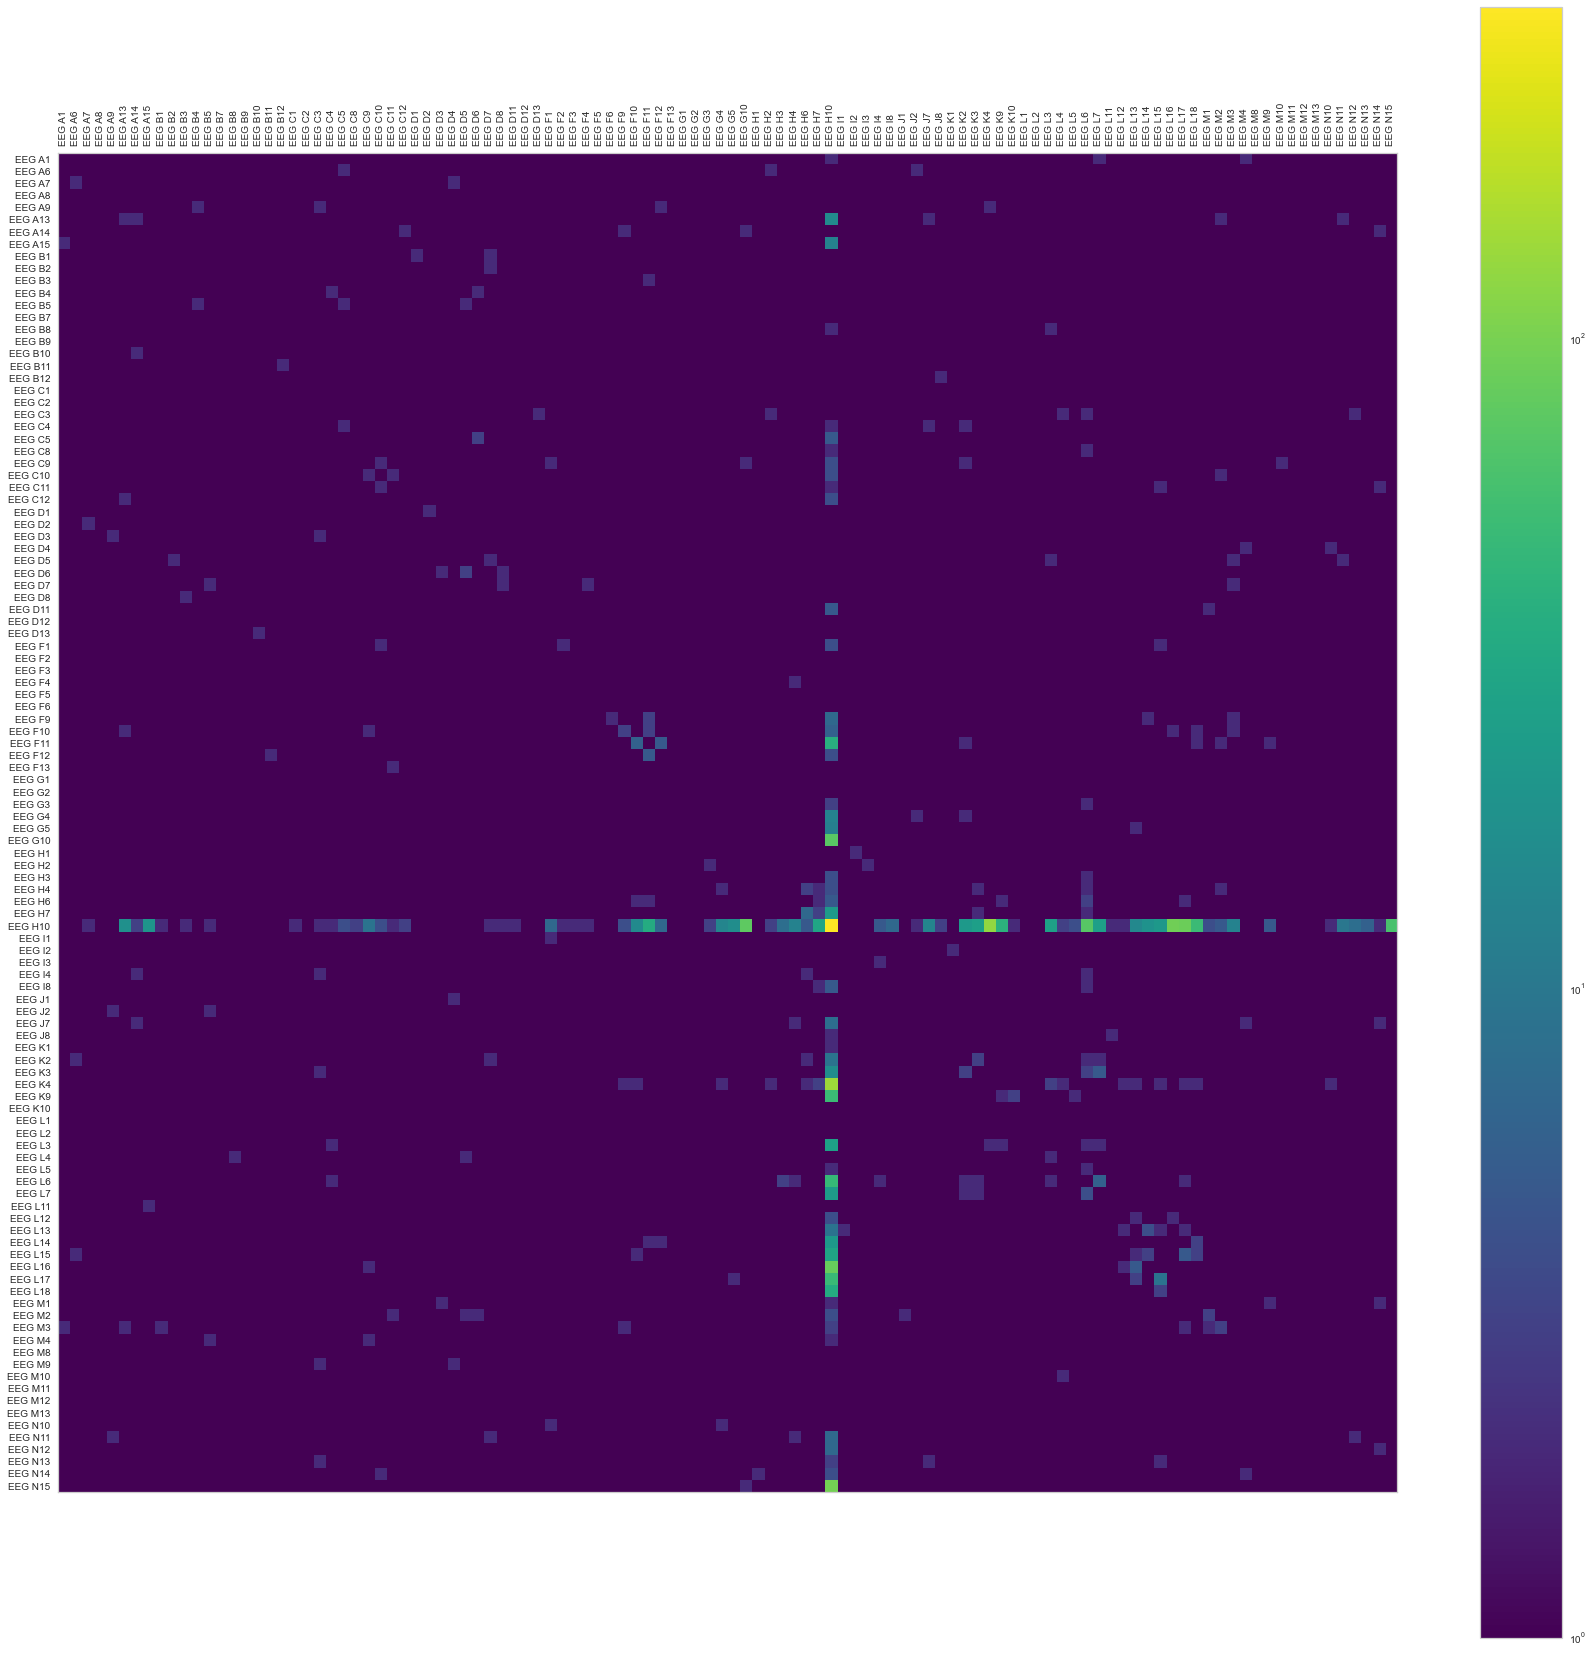

In [94]:
matshow_cluster(4)

Work out the most common routes within IED sequences and display the top 20.

In [96]:
# If a sequence is A -> B -> C, count A -> B as one connection and B -> C as another.
starts_list = [chan[:-1] for chan in all_seq_chans if len(chan) >= 2]
ends_list = [chan[1:] for chan in all_seq_chans if len(chan) >= 2]

pairs = []

for starts, ends in zip(starts_list, ends_list):
    for start, end in zip(starts, ends):
        pairs.append([int(start), int(end)])

unique, counts = np.unique(pairs, return_counts=True, axis=0)

sorted_counts = np.flip(np.argsort(counts))
counts = counts[sorted_counts]
unique = unique[sorted_counts]

for u, c in zip(unique, counts):
    print(c, valid_channels[u[0]], '->', valid_channels[u[1]])

2089 EEG L17 -> EEG L16
1818 EEG L17 -> EEG L18
1688 EEG L18 -> EEG L17
1410 EEG L16 -> EEG L15
1180 EEG L16 -> EEG L17
1174 EEG L18 -> EEG L16
822 EEG L15 -> EEG L16
780 EEG L16 -> EEG L18
700 EEG K4 -> EEG L6
590 EEG L17 -> EEG L15
573 EEG L15 -> EEG L14
394 EEG F11 -> EEG F10
378 EEG L15 -> EEG L17
368 EEG L6 -> EEG L7
356 EEG L18 -> EEG L15
324 EEG H10 -> EEG H10
285 EEG L16 -> EEG L14
284 EEG L6 -> EEG K2
272 EEG L14 -> EEG L15
266 EEG K2 -> EEG L6
247 EEG F11 -> EEG F12
242 EEG F12 -> EEG F11
234 EEG L15 -> EEG L18
221 EEG L15 -> EEG L13
212 EEG K4 -> EEG K9
207 EEG K4 -> EEG K2
206 EEG L13 -> EEG L14
205 EEG F10 -> EEG F11
202 EEG G10 -> EEG G10
194 EEG L16 -> EEG L13
189 EEG L13 -> EEG L15
185 EEG L17 -> EEG L14
183 EEG L7 -> EEG K4
181 EEG K9 -> EEG K4
175 EEG L14 -> EEG L13
172 EEG K3 -> EEG K4
171 EEG L14 -> EEG L16
167 EEG L6 -> EEG K4
155 EEG K4 -> EEG H10
150 EEG K2 -> EEG L7
143 EEG L14 -> EEG L17
139 EEG K3 -> EEG L7
136 EEG H10 -> EEG K4
134 EEG L7 -> EEG L6
133 EEG K4

5 EEG F1 -> EEG M2
5 EEG J7 -> EEG J8
5 EEG K3 -> EEG L4
5 EEG K3 -> EEG L5
5 EEG B1 -> EEG B4
5 EEG K1 -> EEG N10
5 EEG L17 -> EEG M2
5 EEG D7 -> EEG M1
5 EEG C2 -> EEG D3
5 EEG D7 -> EEG J2
5 EEG C2 -> EEG D5
5 EEG F4 -> EEG F5
5 EEG F4 -> EEG L11
5 EEG C3 -> EEG C5
5 EEG I3 -> EEG G3
5 EEG D8 -> EEG C5
5 EEG L18 -> EEG A13
5 EEG L16 -> EEG G5
5 EEG H7 -> EEG L18
5 EEG L6 -> EEG K10
5 EEG B4 -> EEG C5
5 EEG C12 -> EEG N15
5 EEG L12 -> EEG H10
5 EEG G4 -> EEG F11
5 EEG G4 -> EEG A13
5 EEG G3 -> EEG L6
5 EEG L6 -> EEG I2
5 EEG G10 -> EEG J7
5 EEG H1 -> EEG H2
5 EEG B3 -> EEG J2
5 EEG D3 -> EEG B2
5 EEG H2 -> EEG L1
5 EEG H2 -> EEG L2
5 EEG G2 -> EEG G3
5 EEG G2 -> EEG D7
5 EEG D3 -> EEG C4
5 EEG D3 -> EEG C5
5 EEG G5 -> EEG N12
5 EEG B4 -> EEG H2
5 EEG D3 -> EEG D6
5 EEG L11 -> EEG L13
5 EEG G5 -> EEG C2
5 EEG L7 -> EEG G4
5 EEG G4 -> EEG L12
5 EEG L7 -> EEG K10
5 EEG B5 -> EEG D4
5 EEG L7 -> EEG L4
5 EEG B5 -> EEG D7
5 EEG J1 -> EEG F1
5 EEG G5 -> EEG K10
5 EEG L7 -> EEG L14
5 EEG G5 

3 EEG N11 -> EEG H7
3 EEG G5 -> EEG A13
3 EEG C1 -> EEG N11
3 EEG C1 -> EEG M10
3 EEG K3 -> EEG B2
3 EEG N11 -> EEG G4
3 EEG H7 -> EEG N11
3 EEG M9 -> EEG H6
3 EEG M1 -> EEG F1
3 EEG D1 -> EEG C2
3 EEG L3 -> EEG I8
3 EEG L3 -> EEG I2
3 EEG H7 -> EEG M2
3 EEG A13 -> EEG B4
3 EEG A13 -> EEG B1
3 EEG C1 -> EEG N14
3 EEG C4 -> EEG A9
3 EEG G4 -> EEG M1
3 EEG K2 -> EEG M9
3 EEG L4 -> EEG G5
3 EEG H10 -> EEG F9
3 EEG K2 -> EEG L12
3 EEG A6 -> EEG A9
3 EEG N13 -> EEG H6
3 EEG C4 -> EEG H7
3 EEG G4 -> EEG I3
3 EEG G4 -> EEG J2
3 EEG G4 -> EEG K1
3 EEG M9 -> EEG D5
3 EEG A6 -> EEG B5
3 EEG J1 -> EEG J7
3 EEG D1 -> EEG K1
3 EEG H10 -> EEG C5
3 EEG G4 -> EEG L7
3 EEG F2 -> EEG K10
3 EEG G4 -> EEG L15
3 EEG I8 -> EEG F1
3 EEG G4 -> EEG L16
3 EEG H10 -> EEG C10
3 EEG L5 -> EEG D5
3 EEG L4 -> EEG M8
3 EEG D2 -> EEG D5
3 EEG D3 -> EEG C3
3 EEG C8 -> EEG F3
3 EEG B2 -> EEG D7
3 EEG F3 -> EEG D4
3 EEG C8 -> EEG F6
3 EEG L6 -> EEG C12
3 EEG B1 -> EEG D1
3 EEG N11 -> EEG A13
3 EEG L6 -> EEG C8
3 EEG K2 -

3 EEG J2 -> EEG D3
3 EEG B4 -> EEG D6
3 EEG F11 -> EEG L7
3 EEG F12 -> EEG G3
3 EEG C3 -> EEG L16
3 EEG C8 -> EEG B8
3 EEG C2 -> EEG M9
3 EEG L12 -> EEG F9
3 EEG F12 -> EEG G1
3 EEG L18 -> EEG G5
3 EEG D4 -> EEG L12
3 EEG K1 -> EEG L3
3 EEG N14 -> EEG A9
3 EEG D7 -> EEG K4
3 EEG F11 -> EEG L12
3 EEG F12 -> EEG A1
3 EEG G1 -> EEG I8
3 EEG I2 -> EEG H2
3 EEG A13 -> EEG K10
2 EEG I1 -> EEG L4
2 EEG A7 -> EEG M9
2 EEG C5 -> EEG B3
2 EEG I1 -> EEG L1
2 EEG N10 -> EEG K3
2 EEG N11 -> EEG M2
2 EEG H6 -> EEG C8
2 EEG N11 -> EEG M1
2 EEG I1 -> EEG F5
2 EEG I1 -> EEG K3
2 EEG A8 -> EEG C4
2 EEG I4 -> EEG F5
2 EEG C9 -> EEG K4
2 EEG I8 -> EEG K3
2 EEG N11 -> EEG C4
2 EEG C4 -> EEG J7
2 EEG C9 -> EEG C12
2 EEG H4 -> EEG M8
2 EEG I1 -> EEG D3
2 EEG C5 -> EEG A7
2 EEG C4 -> EEG K9
2 EEG C9 -> EEG K3
2 EEG H6 -> EEG C4
2 EEG I4 -> EEG G1
2 EEG I1 -> EEG C11
2 EEG I8 -> EEG K9
2 EEG C9 -> EEG D4
2 EEG I1 -> EEG F2
2 EEG C9 -> EEG D7
2 EEG I1 -> EEG L5
2 EEG C9 -> EEG K2
2 EEG A8 -> EEG F4
2 EEG C4 -> 

2 EEG G1 -> EEG N11
2 EEG D3 -> EEG D2
2 EEG D3 -> EEG D1
2 EEG G2 -> EEG C2
2 EEG G2 -> EEG C9
2 EEG G2 -> EEG D1
2 EEG D3 -> EEG C2
2 EEG G2 -> EEG D5
2 EEG G2 -> EEG D6
2 EEG D3 -> EEG B9
2 EEG G2 -> EEG F4
2 EEG G2 -> EEG F6
2 EEG G2 -> EEG F9
2 EEG N13 -> EEG L7
2 EEG G2 -> EEG G5
2 EEG G2 -> EEG H2
2 EEG G2 -> EEG H7
2 EEG A1 -> EEG N10
2 EEG G2 -> EEG K2
2 EEG G2 -> EEG K3
2 EEG G2 -> EEG K9
2 EEG G2 -> EEG K10
2 EEG G2 -> EEG L3
2 EEG G2 -> EEG L6
2 EEG G1 -> EEG L3
2 EEG G1 -> EEG J7
2 EEG G5 -> EEG G3
2 EEG G1 -> EEG J1
2 EEG D3 -> EEG M10
2 EEG F13 -> EEG H7
2 EEG D3 -> EEG M2
2 EEG F13 -> EEG J8
2 EEG F13 -> EEG L4
2 EEG D3 -> EEG L11
2 EEG D3 -> EEG L3
2 EEG D3 -> EEG L1
2 EEG F13 -> EEG N11
2 EEG G1 -> EEG A8
2 EEG G1 -> EEG C1
2 EEG G1 -> EEG C9
2 EEG G1 -> EEG D1
2 EEG D3 -> EEG H2
2 EEG D3 -> EEG G5
2 EEG G1 -> EEG D5
2 EEG D3 -> EEG G4
2 EEG G1 -> EEG F2
2 EEG D3 -> EEG G3
2 EEG G1 -> EEG F9
2 EEG G1 -> EEG F13
2 EEG G1 -> EEG G4
2 EEG G1 -> EEG G5
2 EEG G1 -> EEG H1


2 EEG J2 -> EEG G4
2 EEG B1 -> EEG B7
2 EEG M2 -> EEG L2
2 EEG J2 -> EEG I2
2 EEG M2 -> EEG M9
2 EEG K2 -> EEG C12
2 EEG M2 -> EEG N13
2 EEG K2 -> EEG D8
2 EEG C2 -> EEG A15
2 EEG K2 -> EEG F6
2 EEG M2 -> EEG N14
2 EEG M2 -> EEG C10
2 EEG C3 -> EEG K4
2 EEG K2 -> EEG H2
2 EEG A14 -> EEG L3
2 EEG J2 -> EEG H1
2 EEG C3 -> EEG L3
2 EEG M3 -> EEG A9
2 EEG J2 -> EEG N10
2 EEG K1 -> EEG J8
2 EEG B1 -> EEG D11
2 EEG J7 -> EEG H6
2 EEG A15 -> EEG I3
2 EEG J8 -> EEG H7
2 EEG M1 -> EEG K4
2 EEG N10 -> EEG B4
2 EEG C2 -> EEG M3
2 EEG M1 -> EEG K1
2 EEG C2 -> EEG M1
2 EEG N10 -> EEG B9
2 EEG C2 -> EEG L16
2 EEG J7 -> EEG A1
2 EEG M1 -> EEG N14
2 EEG A15 -> EEG L6
2 EEG J8 -> EEG L2
2 EEG M1 -> EEG H6
2 EEG C3 -> EEG D6
2 EEG C2 -> EEG L7
2 EEG J8 -> EEG L11
2 EEG M1 -> EEG H4
2 EEG A14 -> EEG L17
2 EEG J8 -> EEG F11
2 EEG A8 -> EEG H1
2 EEG J8 -> EEG F1
2 EEG J7 -> EEG M8
2 EEG J7 -> EEG M4
2 EEG M1 -> EEG L17
2 EEG J8 -> EEG A9
2 EEG M2 -> EEG L7
2 EEG C3 -> EEG B2
2 EEG C3 -> EEG B1
2 EEG M1 -> 

1 EEG C8 -> EEG M8
1 EEG A7 -> EEG G1
1 EEG C1 -> EEG K2
1 EEG A7 -> EEG F10
1 EEG A7 -> EEG F11
1 EEG A9 -> EEG A8
1 EEG C8 -> EEG L17
1 EEG C1 -> EEG K3
1 EEG A7 -> EEG F12
1 EEG C1 -> EEG K4
1 EEG C9 -> EEG A13
1 EEG C1 -> EEG J2
1 EEG C9 -> EEG B2
1 EEG C9 -> EEG B8
1 EEG A9 -> EEG D5
1 EEG A9 -> EEG D3
1 EEG A9 -> EEG D2
1 EEG C9 -> EEG D13
1 EEG A7 -> EEG F2
1 EEG A9 -> EEG D1
1 EEG C1 -> EEG F4
1 EEG C1 -> EEG G1
1 EEG C1 -> EEG G2
1 EEG C1 -> EEG G3
1 EEG C1 -> EEG G10
1 EEG A7 -> EEG F4
1 EEG A7 -> EEG F6
1 EEG C1 -> EEG H6
1 EEG C9 -> EEG C3
1 EEG C9 -> EEG C2
1 EEG C9 -> EEG C1
1 EEG C1 -> EEG K9
1 EEG A8 -> EEG N15
1 EEG C9 -> EEG F5
1 EEG C8 -> EEG G4
1 EEG C2 -> EEG A1
1 EEG C2 -> EEG A6
1 EEG A8 -> EEG M3
1 EEG A7 -> EEG I8
1 EEG D12 -> EEG J2
1 EEG A8 -> EEG L18
1 EEG C8 -> EEG H2
1 EEG A7 -> EEG J2
1 EEG A7 -> EEG K2
1 EEG A8 -> EEG N12
1 EEG C8 -> EEG G3
1 EEG C8 -> EEG G2
1 EEG C8 -> EEG G1
1 EEG A8 -> EEG L17
1 EEG A8 -> EEG L15
1 EEG A7 -> EEG K9
1 EEG C8 -> EEG F1

1 EEG B8 -> EEG H10
1 EEG A6 -> EEG D5
1 EEG D1 -> EEG B5
1 EEG D1 -> EEG B4
1 EEG B8 -> EEG I3
1 EEG B8 -> EEG I4
1 EEG B8 -> EEG I8
1 EEG B8 -> EEG J8
1 EEG B9 -> EEG C4
1 EEG B9 -> EEG C5
1 EEG C12 -> EEG L16
1 EEG C12 -> EEG D2
1 EEG B9 -> EEG I2
1 EEG B9 -> EEG J7
1 EEG B9 -> EEG K1
1 EEG B9 -> EEG L1
1 EEG B9 -> EEG L5
1 EEG A6 -> EEG J8
1 EEG B9 -> EEG L16
1 EEG B9 -> EEG M2
1 EEG B9 -> EEG M4
1 EEG A6 -> EEG K1
1 EEG A6 -> EEG K9
1 EEG A6 -> EEG K10
1 EEG A6 -> EEG L2
1 EEG C12 -> EEG C5
1 EEG C12 -> EEG C3
1 EEG C12 -> EEG C2
1 EEG C12 -> EEG C1
1 EEG B9 -> EEG I1
1 EEG B9 -> EEG F11
1 EEG C12 -> EEG L14
1 EEG B9 -> EEG F4
1 EEG B9 -> EEG C8
1 EEG C12 -> EEG L6
1 EEG C12 -> EEG L3
1 EEG B9 -> EEG C9
1 EEG B9 -> EEG C10
1 EEG C12 -> EEG K1
1 EEG B9 -> EEG C11
1 EEG C12 -> EEG I4
1 EEG B9 -> EEG D8
1 EEG C12 -> EEG G5
1 EEG C12 -> EEG G3
1 EEG C12 -> EEG F5
1 EEG C12 -> EEG F4
1 EEG C12 -> EEG F1
1 EEG B9 -> EEG D13
1 EEG C12 -> EEG D3
1 EEG B9 -> EEG F1
1 EEG A14 -> EEG M2
1 EE

1 EEG N11 -> EEG K1
1 EEG N11 -> EEG I8
1 EEG N11 -> EEG I4
1 EEG N11 -> EEG H3
1 EEG N11 -> EEG H1
1 EEG N11 -> EEG G10
1 EEG N11 -> EEG G2
1 EEG N11 -> EEG F11
1 EEG N11 -> EEG D12
1 EEG N11 -> EEG D3
1 EEG N11 -> EEG C12
1 EEG N11 -> EEG C2
1 EEG N11 -> EEG C1
1 EEG N11 -> EEG B12
1 EEG N11 -> EEG B8
1 EEG N11 -> EEG B2
1 EEG N11 -> EEG A15
1 EEG N11 -> EEG A7
1 EEG N11 -> EEG A1
1 EEG N10 -> EEG A15
1 EEG N10 -> EEG A7
1 EEG N11 -> EEG N11
1 EEG M11 -> EEG N12
1 EEG M11 -> EEG M12
1 EEG M11 -> EEG L7
1 EEG M11 -> EEG K3
1 EEG M11 -> EEG J7
1 EEG M11 -> EEG J2
1 EEG M11 -> EEG J1
1 EEG M11 -> EEG I8
1 EEG M11 -> EEG I3
1 EEG M11 -> EEG F4
1 EEG M11 -> EEG D8
1 EEG M11 -> EEG C8
1 EEG M11 -> EEG B10
1 EEG M11 -> EEG B7
1 EEG M11 -> EEG A9
1 EEG M10 -> EEG N14
1 EEG M10 -> EEG N10
1 EEG M10 -> EEG M3
1 EEG M10 -> EEG M2
1 EEG M10 -> EEG L17
1 EEG M10 -> EEG L12
1 EEG M10 -> EEG L7
1 EEG M10 -> EEG L2
1 EEG M10 -> EEG K1
1 EEG M10 -> EEG J8
1 EEG M10 -> EEG J1
1 EEG M10 -> EEG I4
1 EEG

1 EEG G4 -> EEG C4
1 EEG G4 -> EEG C2
1 EEG G4 -> EEG C1
1 EEG G4 -> EEG B9
1 EEG G4 -> EEG B4
1 EEG G4 -> EEG B3
1 EEG G4 -> EEG B2
1 EEG G4 -> EEG A9
1 EEG G4 -> EEG A8
1 EEG G3 -> EEG N15
1 EEG G3 -> EEG N13
1 EEG G3 -> EEG N12
1 EEG G3 -> EEG M10
1 EEG G3 -> EEG M4
1 EEG G3 -> EEG M3
1 EEG G3 -> EEG M1
1 EEG G3 -> EEG L18
1 EEG G3 -> EEG L7
1 EEG G3 -> EEG L3
1 EEG G3 -> EEG L2
1 EEG G4 -> EEG F9
1 EEG G4 -> EEG G1
1 EEG G3 -> EEG J8
1 EEG G4 -> EEG H1
1 EEG G5 -> EEG D7
1 EEG G5 -> EEG D6
1 EEG G5 -> EEG D4
1 EEG G5 -> EEG D3
1 EEG G5 -> EEG D2
1 EEG G5 -> EEG C12
1 EEG G5 -> EEG C3
1 EEG G5 -> EEG C1
1 EEG G5 -> EEG B7
1 EEG G5 -> EEG B5
1 EEG G5 -> EEG B2
1 EEG G5 -> EEG B1
1 EEG G5 -> EEG A14
1 EEG G5 -> EEG A8
1 EEG G5 -> EEG A7
1 EEG G5 -> EEG A6
1 EEG G4 -> EEG N14
1 EEG G4 -> EEG N13
1 EEG G4 -> EEG N10
1 EEG G4 -> EEG M9
1 EEG G4 -> EEG L11
1 EEG G4 -> EEG L3
1 EEG G4 -> EEG L1
1 EEG G4 -> EEG J8
1 EEG G4 -> EEG I8
1 EEG G4 -> EEG I4
1 EEG G4 -> EEG I1
1 EEG G4 -> EEG H3
1

1 EEG J2 -> EEG B1
1 EEG J2 -> EEG A6
1 EEG J1 -> EEG N15
1 EEG J1 -> EEG N14
1 EEG J1 -> EEG L18
1 EEG J1 -> EEG L14
1 EEG J1 -> EEG L7
1 EEG J1 -> EEG K9
1 EEG J1 -> EEG K2
1 EEG J1 -> EEG J8
1 EEG J1 -> EEG I3
1 EEG J1 -> EEG I2
1 EEG J1 -> EEG I1
1 EEG J1 -> EEG H6
1 EEG J1 -> EEG H4
1 EEG J1 -> EEG H1
1 EEG J1 -> EEG G3
1 EEG J1 -> EEG F6
1 EEG J1 -> EEG F3
1 EEG J1 -> EEG C8
1 EEG J1 -> EEG C2
1 EEG J1 -> EEG B2
1 EEG I1 -> EEG C3
1 EEG I1 -> EEG C2
1 EEG I1 -> EEG B7
1 EEG H2 -> EEG J1
1 EEG H2 -> EEG G10
1 EEG H2 -> EEG F9
1 EEG H2 -> EEG F1
1 EEG H2 -> EEG D6
1 EEG H2 -> EEG D2
1 EEG H2 -> EEG D1
1 EEG H2 -> EEG C11
1 EEG H2 -> EEG C9
1 EEG H2 -> EEG C8
1 EEG H2 -> EEG C5
1 EEG H2 -> EEG B10
1 EEG H2 -> EEG B9
1 EEG H2 -> EEG B1
1 EEG H2 -> EEG A14
1 EEG H2 -> EEG A13
1 EEG H2 -> EEG A9
1 EEG H2 -> EEG A6
1 EEG H1 -> EEG N12
1 EEG H1 -> EEG M4
1 EEG H1 -> EEG L13
1 EEG H1 -> EEG L11
1 EEG H1 -> EEG L2
1 EEG H1 -> EEG K9
1 EEG H1 -> EEG K4
1 EEG H1 -> EEG K3
1 EEG H1 -> EEG K2


Plot a heatmap with the frequency of each connection.

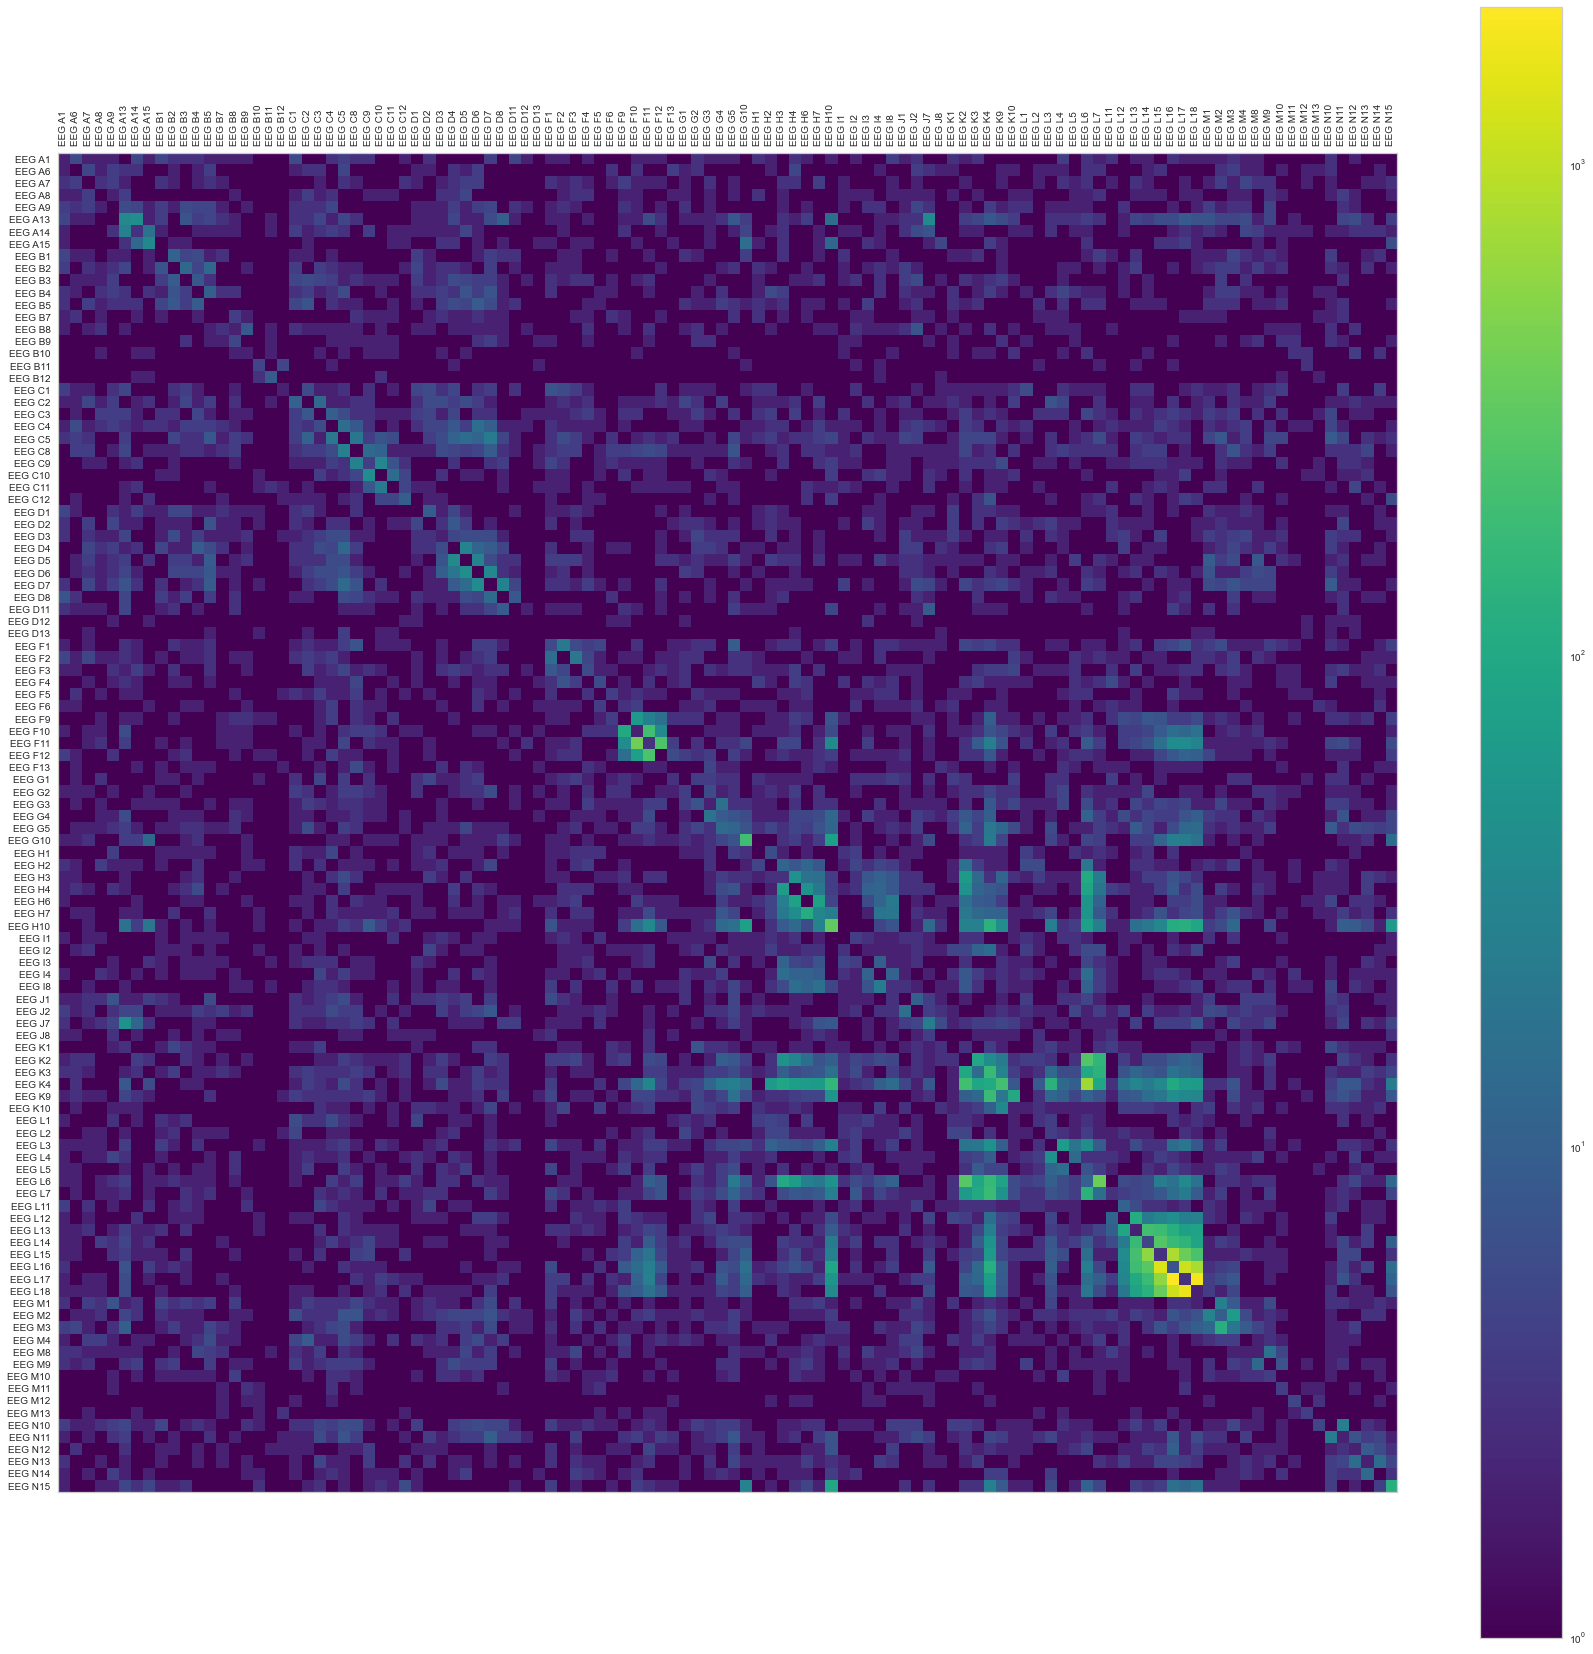

In [97]:
matshow_cluster()

As above but just for one electrode (in this case L).

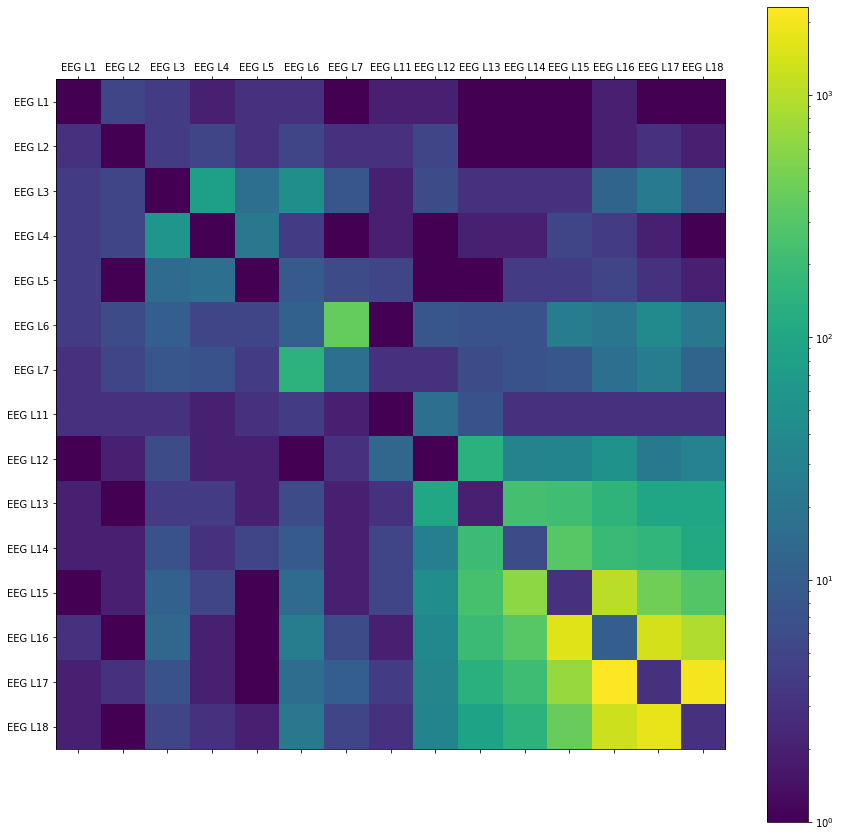

In [176]:
matplotlib.rcParams['figure.figsize'] = (15, 15)

# Get indices of first and last contact on electrode
first_chan_idx = valid_channels.index('EEG L1')
last_chan_idx = valid_channels.index('EEG L18')

# Get slice of original array
subset_counts_mat = counts_mat[first_chan_idx : last_chan_idx + 1, \
                               first_chan_idx : last_chan_idx + 1]
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(subset_counts_mat + 1, interpolation='nearest', norm=LogNorm())
fig.colorbar(cax)

xaxis = np.arange(last_chan_idx + 1 - first_chan_idx)
ax.set_xticks(xaxis)
ax.set_yticks(xaxis)
ax.set_xticklabels(valid_channels[first_chan_idx : last_chan_idx + 1])
ax.set_yticklabels(valid_channels[first_chan_idx : last_chan_idx + 1])

plt.show()

Create histogram for IED sequence length

[Text(0.5, 0, 'IED sequence duration (ms)')]

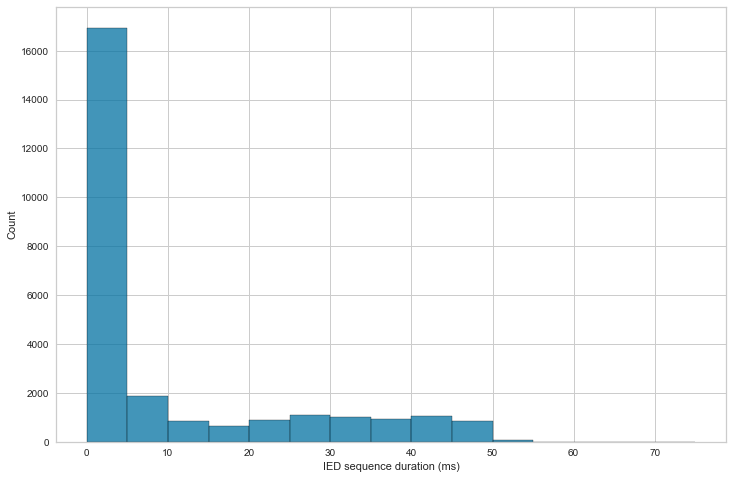

In [98]:
matplotlib.rcParams['figure.figsize'] = (12, 8)

# Work out lengths for each sequence and convert to ms
length_list = [(1000/freq) * (spike[-1] - spike[0]) for spike in all_seq_spikes if len(spike) > 1]

ax = sns.histplot(length_list, bins=15, binrange=[0, 75])
ax.set(xlabel='IED sequence duration (ms)')

Plot histogram of IED frequency over time 

/Users/jamienorris/miniconda3/envs/lightgbm/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/jamienorris/miniconda3/envs/lightgbm/lib/python3.9/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.04 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

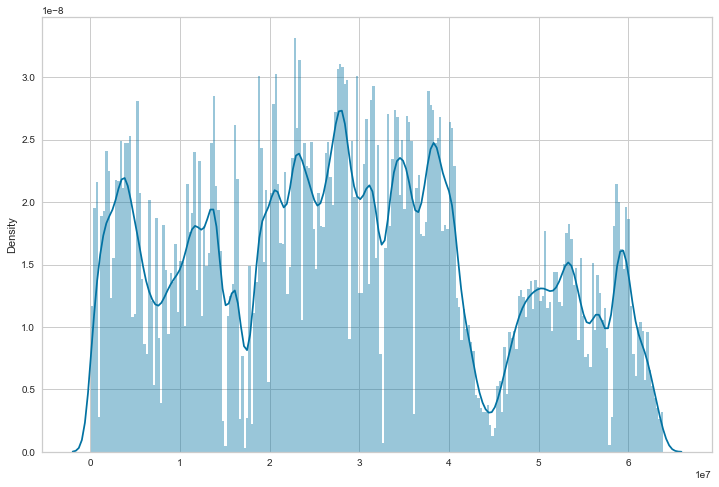

In [99]:
sequence_starts = [spike[0] for spike in all_seq_spikes]
sns.distplot(sequence_starts, bins=240, kde_kws={"bw": 0.04})

Plot histogram of inter-IED intervals, but this time using sequences rather than per-channel

Text(0.5, 8.959999999999994, 'Time (s)')

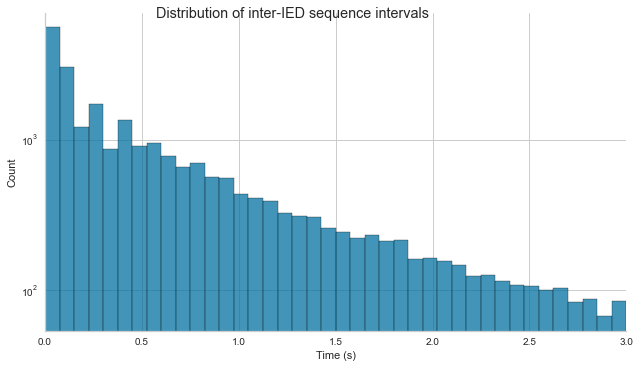

In [100]:
# Difference in time between IEDs
diffs = np.diff(np.array([spikes[0] for spikes in all_seq_spikes if len(spikes) > 1]))

# Only keep intervals < 3s
filtered_diffs = diffs[diffs / freq < 3]

# Plot using histogram
g = sns.displot(filtered_diffs / 2048, bins=40)

g.fig.suptitle('Distribution of inter-IED sequence intervals')
g.fig.set_size_inches(10,5)
g.set(xlim=(0, 3))

# Optionally use log scale
g.ax.set_yscale('log')
plt.xlabel('Time (s)')

Produce a matrix showing the Euclidean distance between each contact in mm

In [5]:
# Define path of positions in voxel space
voxels_path = 'Data/TrialPatientBeSa/BeSA/sub-01/ElectrodesTransformed/'

# Get list of electrodes (ordered)
electrodes = list(dict.fromkeys([channel[4] for channel in valid_channels]))
voxels = {}

# Open each CSV as a pandas dataframe, adding 1 to the index for 1-indexing
for electrode in electrodes:
    voxels[electrode] = pd.read_csv(voxels_path + electrode + \
                                    '_voxel_space.fcsv', delimiter=' ', \
                                    header=None, names=['x', 'y', 'z'])
    voxels[electrode].index += 1
    

# Produce the distance matrix
distance_mat = np.zeros((len(valid_channels), len(valid_channels)))

# Iterate through all channels (each is a starting contact)
for i, start in enumerate(valid_channels):
    start_coord = voxels[start[4]].loc[int(start[5:])]
    # Iterate through all channels (distance to each contact, for each start)
    for j, end in enumerate(valid_channels):
        end_coord = voxels[end[4]].loc[int(end[5:])].to_numpy()
        # Calculate Euclidean distance (mm)
        distance_mat[i][j] = np.linalg.norm(start_coord - end_coord)

Plot the distances in a matrix

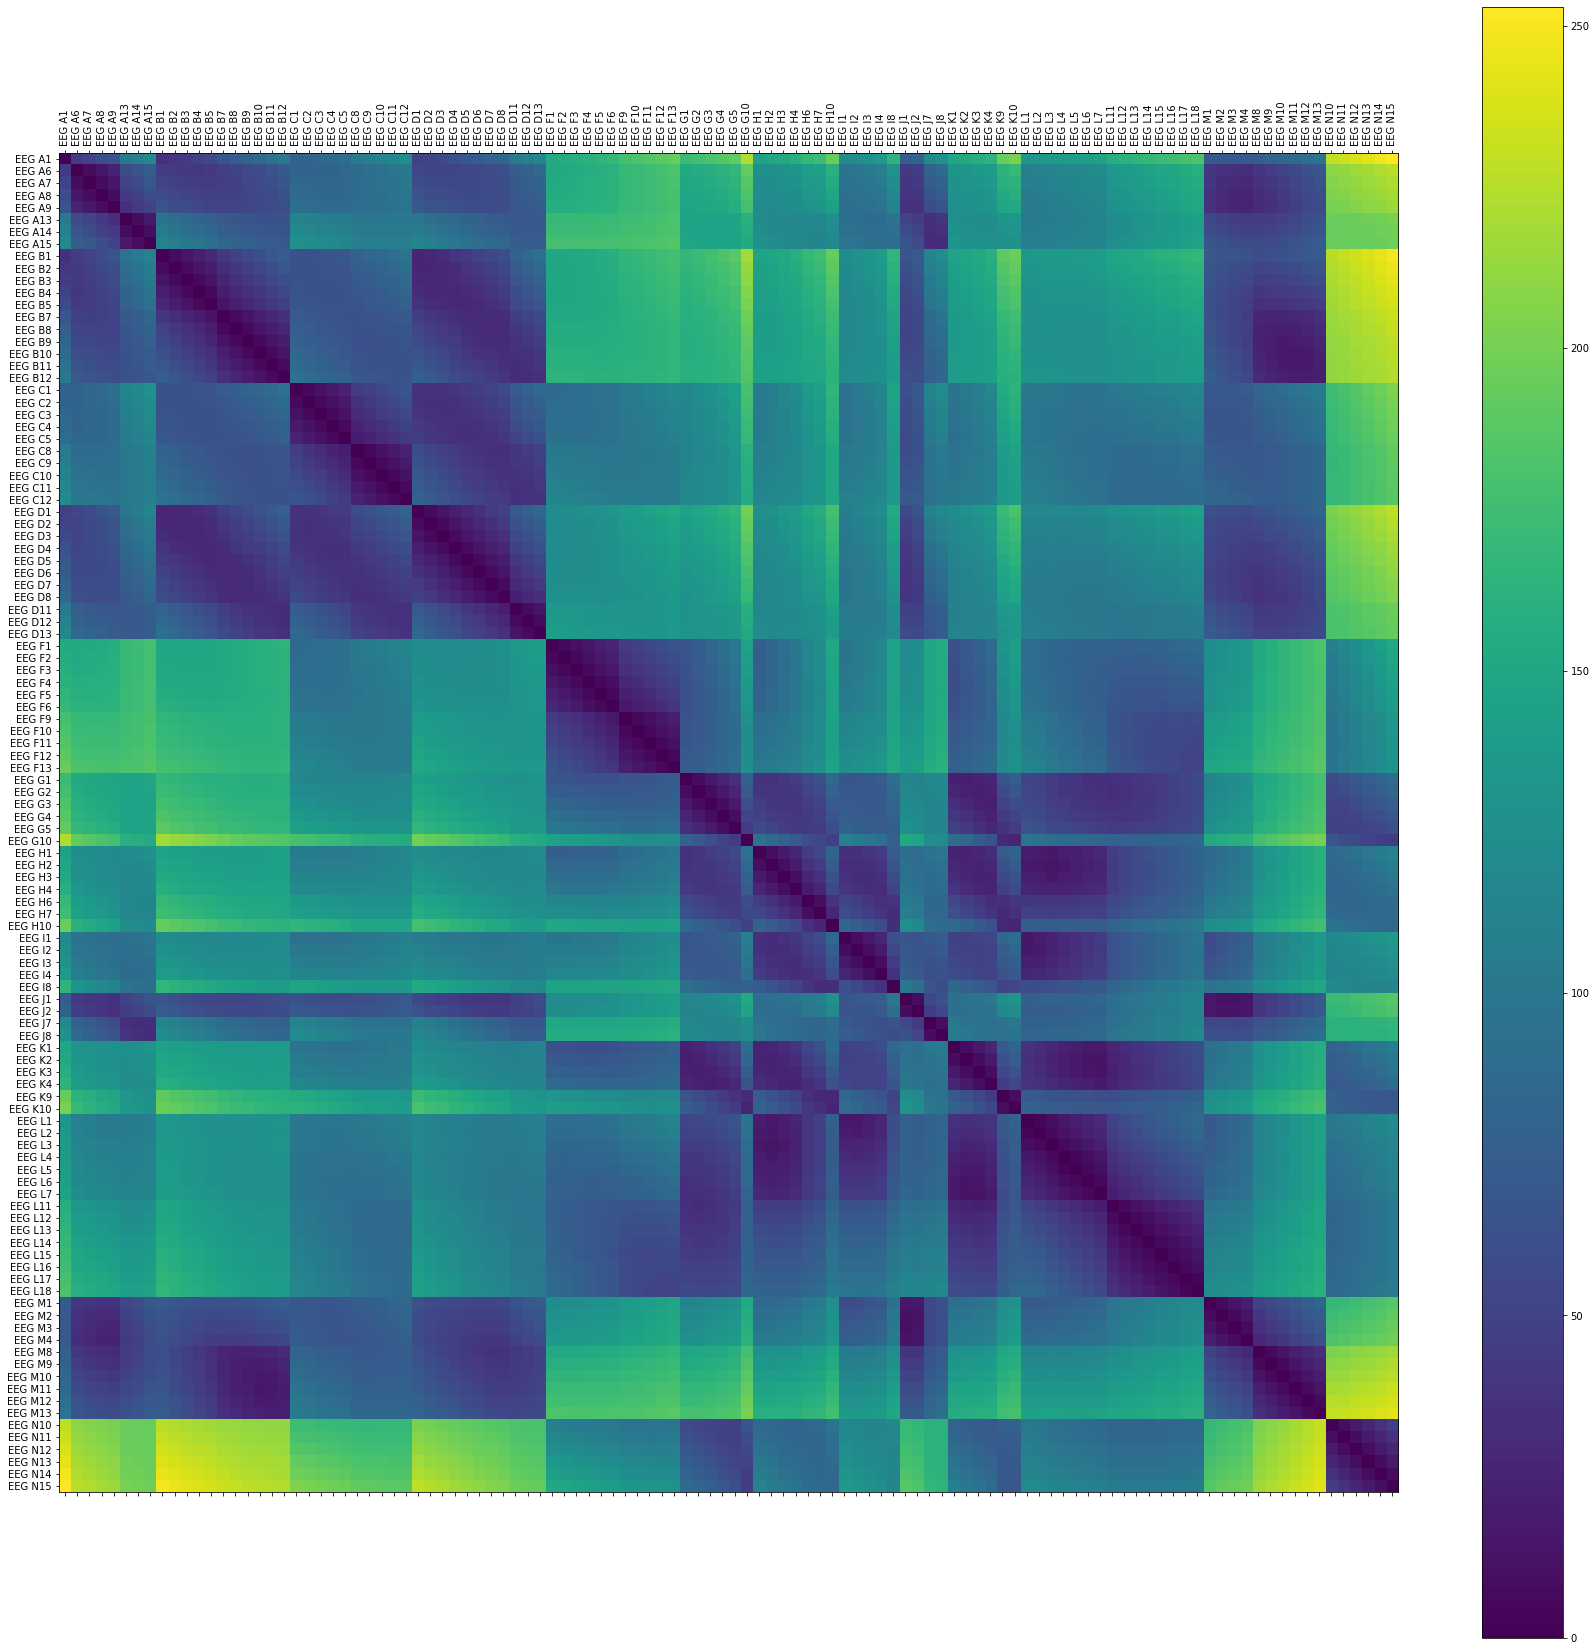

In [217]:
matplotlib.rcParams['figure.figsize'] = (30, 30)

# Display as a heatmap
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(distance_mat, interpolation='nearest')#, norm=LogNorm())
fig.colorbar(cax)

# Set ticks as appropriate
xaxis = np.arange(chans)
ax.set_xticks(xaxis)
ax.set_yticks(xaxis)
ax.set_xticklabels(valid_channels, rotation=90)
ax.set_yticklabels(valid_channels)

plt.show()

Produce the connectivity matrix ordered by Euclidean distance from the channel with the most IEDs

In [101]:
# matplotlib.rcParams['figure.figsize'] = (30, 30)

# most_IEDs_chan = np.argmax(np.bincount(ChanIds))
# ordered_by_distance = np.argsort(distance_mat[most_IEDs_chan])

# # Produce the matrix
# ordered_counts_mat = np.zeros((len(valid_channels), len(valid_channels)))
# for c, u in zip(counts, unique):
#     ordered_counts_mat[ordered_by_distance[u[0]], ordered_by_distance[u[1]]] = c

# # Display as a heatmap
# fig = plt.figure()
# ax = fig.add_subplot(111)
# cax = ax.matshow(ordered_counts_mat + 1, interpolation='nearest', norm=LogNorm())
# fig.colorbar(cax)

# # Set ticks as appropriate
# xaxis = np.arange(chans)
# ax.set_xticks(xaxis)
# ax.set_yticks(xaxis)
# ax.set_xticklabels(np.array(valid_channels)[ordered_by_distance], rotation=90)
# ax.set_yticklabels(np.array(valid_channels)[ordered_by_distance])

# plt.show()

May/may not be used in the future, e.g. feature extraction:

In [39]:
# In minutes
mins_to_process=20

# Time points
M = f.getNSamples()[0]

SpikeIds = []
ChanIds = []
features = []
feature_names = []

# Duration of recording in seconds
NumSecs = M / freq
Blocks = math.floor(NumSecs / (mins_to_process * 60))

# TODO do we loop through final iteration correctly? Depends on Blocks calculation 
# Iterate through each block of mins_to_process minutes
# TODO use full dataset eventually (currently using subset)
for current_block in tqdm(range(4, 30)):

    data_block = np.zeros((len(valid_channels), freq * 60 * mins_to_process))

    # Populate area of data for the current block across all channels
    for i, chan in enumerate(valid_channels):

        data_block[i, :] = f.readSignal(signal_labels.index(chan), \
                                        start = current_block * freq * 60 * mins_to_process, \
                                        n = freq * 60 * mins_to_process)

    # Detect IEDs in current block across all chanels
    SpikeIndex, ChanId, _ = DetectSpikes(data_block, freq, STDCoeff=2)
    
    # Add to list across all blocks, corrected for index of block start
    SpikeIds.append(SpikeIndex + current_block * freq * 60 * mins_to_process)
    ChanIds.append(ChanId)
    
    data_block_scaled = preprocessing.scale(data_block.copy(), axis=1, with_std=True)
    
    for second in range(mins_to_process * 60):
        
        features_second = []
                        
        # get correlation Coef. this will be 16x16
        h = np.corrcoef(data_block_scaled[:, second * freq : (second + 1) * freq])
        h = np.nan_to_num(h)
        
        # only want upper triangle
        ind = np.triu_indices(len(valid_channels), 1)
        htri = h[ind]
#         for ii in range(np.size(htri)):
#             features_second.append(htri[ii])

        c, v = np.linalg.eig(h)
        c.sort()
        c = np.real(c)
        for e in range(len(c)):
            features_second.append(c[e])
        
        for chan in data_block_scaled:
            f_psd, psd = signal.welch(chan[second * freq : (second + 1) * freq].copy(), fs=freq, nperseg=1024)
            psd = np.nan_to_num(psd)
            psd /= psd.sum()
            bands = [0.1, 4, 8, 12, 30, 70, 180]

            for c in range(1, len(bands)):
                features_second.append(psd[(f_psd > bands[c-1]) & (f_psd < bands[c])].sum())

            hold = signal.decimate(chan[second * freq : (second + 1) * freq].copy(), 5, zero_phase=True)
            
            features_second.append(hold.std())
            features_second.append(stats.kurtosis(hold))
            features_second.append(stats.skew(hold))
            features_second.append(((hold[:-1] * hold[1:]) < 0).sum())
            
            diff = np.diff(hold, n=1) 
            diff2 = np.diff(hold,n=2)
            
            features_second.append(diff.std())
            features_second.append(diff2.std())
            
            features_second.append(((diff[:-1] * diff[1:]) < 0).sum())
            features_second.append(((diff2[:-1] * diff2[1:]) < 0).sum())

            features_second.append(np.sqrt((hold**2).mean()))
            f_psd, psd = signal.welch(hold, fs=freq // 5, nperseg=1024 // 5)
            psd[0] = 0

            features_second.append(psd.argmax())
            psd_sum = psd.sum()
            features_second.append(psd_sum)
            if psd_sum > 0:
                psd /= psd.sum()
            
            features_second.append(-1.0*np.sum(psd[f_psd>bands[0]]*np.log10(psd[f_psd>bands[0]])))
            features_second.append(np.std(diff)/hold.std())
            features_second.append(np.std(diff2)*np.std(hold)/(np.std(diff)**2.))
                          
        features.append(features_second)

# Convert to numpy arrays
SpikeIds = np.concatenate(SpikeIds, axis=0)
ChanIds = np.concatenate(ChanIds, axis=0)
features = np.array(features)

  0%|                                                    | 0/26 [00:00<?, ?it/s]/Users/jamienorris/miniconda3/envs/lightgbm/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  The triangular window, with the maximum value normalized to one
/Users/jamienorris/miniconda3/envs/lightgbm/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  (the value one appears only if the number of samples is odd), with
/var/folders/s8/yc5ds6dn11ncxwggkx3c6wrc0000gn/T/ipykernel_17148/3163491436.py:62: RuntimeWarning: invalid value encountered in true_divide
  psd /= psd.sum()
  8%|███▏                                     | 2/26 [09:16<1:50:01, 275.06s/it]/Users/jamienorris/miniconda3/envs/lightgbm/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  The triangular window, with the maximum value normalized t

 85%|███████████████████████████████▎     | 22/26 [6:25:52<1:50:46, 1661.55s/it]/Users/jamienorris/miniconda3/envs/lightgbm/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  The triangular window, with the maximum value normalized to one
/Users/jamienorris/miniconda3/envs/lightgbm/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  (the value one appears only if the number of samples is odd), with
/var/folders/s8/yc5ds6dn11ncxwggkx3c6wrc0000gn/T/ipykernel_17148/3163491436.py:62: RuntimeWarning: invalid value encountered in true_divide
  psd /= psd.sum()
 92%|████████████████████████████████████▉   | 24/26 [6:35:18<31:59, 959.61s/it]/Users/jamienorris/miniconda3/envs/lightgbm/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  The triangular window, with the maximum value normalized t

In [24]:
SpikeIds.min() / (60*2048)

80.41591796875

In [40]:
SpikeIds = SpikeIds - 60 * 2048 * 80

In [41]:
np.save('features.npy', features)
np.save('SpikeIds.npy', SpikeIds)
np.save('ChanIds.npy', ChanIds)

In [60]:
X = features.copy()

y = []

for second in range(len(X)):
    y.append(len(SpikeIds[np.logical_and(SpikeIds > second * 2048, SpikeIds < (second + 1) * 2048)]))
    
y = np.array(y)

In [61]:
imp = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
X_new = imp.fit_transform(X)

X_train = X_new[:-1]
y_train = y[1:]

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [65]:
np.save('XGB/X_train.npy', X_train)
np.save('XGB/X_test.npy', X_test)
np.save('XGB/y_train.npy', y_train)
np.save('XGB/y_test.npy', y_test)

In [ ]:
all_seq_spikes, all_seq_chans = spikes_to_sequences(SpikeIds, ChanIds)

In [66]:
y_sequences = [0] * y.shape[0]
for spike in all_seq_spikes:
    y_sequences[int(spike[0] // 2048)] += 1
y_sequences = y_sequences[1:]
;     
y_sequences_train, y_sequences_test = train_test_split(np.array(y_sequences), test_size=0.2, random_state=42)

In [68]:
np.save('XGB/X_train.npy', X_train)
np.save('XGB/X_test.npy', X_test)
np.save('XGB/y_train.npy', y_sequences_train)
np.save('XGB/y_test.npy', y_sequences_test)

In [24]:
y_clusters = np.zeros((y.shape[0], n_clusters + 1))
for cluster, spike in zip(assigned_clusters, all_seq_spikes):
    y_clusters[int(spike[0] // 2048), cluster + 1] += 1
y_clusters = y_clusters[1:]

y_cluster_train, y_cluster_test = train_test_split(y_clusters.argmax(axis=1), test_size=0.2, random_state=42)

In [25]:
np.save('XGB/y_cluster_train.npy', y_cluster_train)
np.save('XGB/y_cluster_test.npy', y_cluster_test)

In [2]:
X_train = np.load('XGB/X_train.npy')
X_test = np.load('XGB/X_test.npy')

# y_train = np.load('XGB/y_train.npy')
# y_test = np.load('XGB/y_test.npy')

y_sequences_train = np.load('XGB/y_sequences_train.npy')
y_sequences_test = np.load('XGB/y_sequences_test.npy')

In [7]:
corrs = []
for i in range(X_test.shape[1]):
    corr = np.abs(np.corrcoef(X_train[:, i], y_sequences_train)[0, 1])
    corrs.append(corr)
#     if corr > 0.164:
#         print(f"{feature_names[i]}: {corr}")
argsort = np.argsort(corrs)
argsort[::-1][:10], np.array(corrs)[argsort[::-1][:10]]
# np.take_along_axis(np.array(feature_names), argsort, axis=0)[::-1][:15]

(array([5655, 1603, 1201,  837, 5365, 1042, 4030, 4703, 1153, 5529]),
 array([8.92455813e-06, 1.34867595e-05, 1.66391039e-05, 1.66556894e-05,
        1.68046053e-05, 2.56937620e-05, 2.98914388e-05, 3.34348918e-05,
        3.51617062e-05, 3.96465021e-05]))

In [205]:
for i in range(X_train.shape[1]):
    corr = np.corrcoef(X_train[:, i], y_sequences_train)[0, 1]
    if corr > 0.05:
        print(feature_names[i], corr)

BandPower_A1_8-12 0.05140902962217822
BandPower_B8_70-180 0.050449589658728325
BandPower_C8_70-180 0.05388435501461877
BandPower_C9_70-180 0.051155988057820234
BandPower_C12_70-180 0.05018315600994282
BandPower_F4_4-8 0.05461024508023853
BandPower_F9_4-8 0.07812641045192442
BandPower_F10_4-8 0.07339144988709441
BandPower_F11_4-8 0.07667294278990906
BandPower_F12_4-8 0.06465770224028014
BandPower_G4_4-8 0.0775558494498743
BandPower_G10_4-8 0.05279231989666072
BandPower_G10_12-30 0.05412523690077717
BandPower_I2_12-30 0.05324458508026303
BandPower_K1_4-8 0.05273977789104498
BandPower_K2_4-8 0.058196711831009613
BandPower_K3_4-8 0.05564209892938193
BandPower_L7_8-12 0.07168316294426708
BandPower_L7_12-30 0.0716212408954839
BandPower_L12_4-8 0.07342201816353577
BandPower_L13_4-8 0.09912523914716817
BandPower_L14_4-8 0.10501073766055227
BandPower_L15_4-8 0.11229663997171549
BandPower_L16_4-8 0.12398170452982711
BandPower_L17_4-8 0.13602706810278004
BandPower_L18_4-8 0.12265928199306159
Band

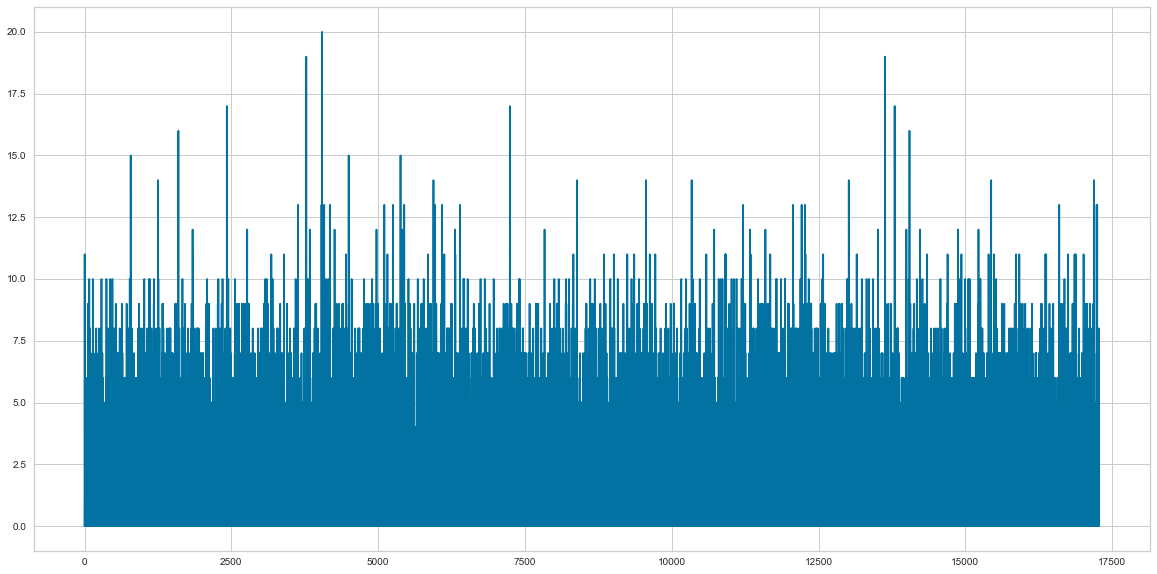

In [13]:
plt.plot(y_sequences_train)

In [213]:
X_train[:, 660:-110].shape, X_train.shape

((17279, 5995), (17279, 6765))

In [214]:
feature_names = []

print(len(valid_channels) * 6)
for chan in valid_channels:
    bands = [0.1, 4, 8, 12, 30, 70, 180]
    for c in range(1, len(bands)):
        feature_names.append("BandPower_" + str(chan[4:]) + "_" + str(bands[c-1]) + "-" + str(bands[c]))

# get correlation Coef. this will be 16x16
h = np.corrcoef(np.zeros((len(valid_channels), len(valid_channels))))
h = np.nan_to_num(h)

# only want upper triangle
ind = np.triu_indices(len(valid_channels), 1)
htri = h[ind]

test = 0
for i, chan1 in enumerate(valid_channels):
    for chan2 in valid_channels[i + 1:]:
        test += 1
        feature_names.append("coef" + "_" + chan1[4:] + "_" + chan2[4:])

print(test)
# for ii in range(np.size(htri)):
#     feature_names.append('coef%i'%(ii))

c, v = np.linalg.eig(h)
c.sort()
c = np.real(c)
for e in range(len(c)):
    feature_names.append('coef_timeEig%i'%(e))
print(len(c))

660
5995
110
